In [1]:
# from sklearnex import patch_sklearn
# patch_sklearn()

# Modeling exercise

## General Instructions

* Submission date: 25.4.2022
* Submission Method: Link to your solution notebook in [this sheet](https://docs.google.com/spreadsheets/d/1fTmjiVxzw_rM1hdh16enwUTtxzlHSJIiw41dJS2LKp0/edit?usp=sharing).

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys; sys.path.append('../Modles and Modeling/src')
import numpy as np
import plotly_express as px

In [4]:
import pandas as pd
import ipywidgets as widgets

In [5]:
from datasets import make_circles_dataframe, make_moons_dataframe

## Fitting and Overfiting 

The goal of the following exercise is to:
* Observe overfitting due to insuffient data
* Observe Overfitting due to overly complex model
* Identify the overfitting point by looking at Train vs Test error dynamic
* Observe how noise levels effect the needed data samples and model capacity

To do so, you'll code an experiment in the first part, and analyze the experiment result in the second part.

### Building an experiment

Code:

1. Create data of size N with noise level of magnitude NL from datasets DS_NAME. 
1. Split it to training and validation data (no need for test set), use 80%-20%. 
1. Use Logistic regression and Choose one complex model of your choice: [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [SVM with RBF kernel](https://scikit-learn.org/stable/modules/svm.html) with different `gamma` values or [Random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with differnt number of `min_samples_split`. 
1. Train on the train set for different hyper parameter values. compute:
   1. Classification accuracy on the training set (TRE)
   1. Classification accuracy on the validation set (TESTE)
   1. The difference beteen the two above (E_DIFF)
1. Save DS_NAME, N, NL, CLF_NAME, K, TRE, TESTE, E_DIFF and the regularization/hyper param (K, gamma or min_samples_split and regularization value for the linear regression classifier)

Repeat for:
* DS_NAME in Moons, Circles
* N (number of samples) in [5, 10, 50, 100, 1000, 10000]
* NL (noise level) in [0, 0.1, 0.2, 0.3, 0.4, 0.5]
* For the complex model: 10 Values of hyper parameter of the complex model you've chosen.
* For the linear model: 5 values of ridge (l2) regularization - [0.001, 0.01, 0.1, 1, 10, 100, 1000]

### Analysing the expermient results

1. For SVM only, For dataset of size 10k and for each dataset, What are the best model params? How stable is it? 
1. For SVM only, For dataset of size 10k and for each dataset, What is the most stable model and model params? How good is it in comparison to other models? Explain using bias and variance terminoligy.
1. Does regularization help for linear models? consider different datasets sizes. 
1. For a given noise level of your chioce, How does the train, test and difference error changes with increasing data sizes? (answer for svm and LR seperatly)
1. For a given noise level of your chioce, How does the train, test and difference error changes with increasing model complexity? (answer for svm and LR seperatly)
1. Are the noise level effect the number of datapoints needed to reach optimal test results? 

Bonus:

* For SVM: Select one dataset and with 0.2 noise level. Identify the optimal model params, and visualize the decision boundry learned. 
  * Hint: Use a grid. See classification models notebook 

## Tips and Hints

For buliding the experiment:

* Start with one dataframe holding all the data for both datastes with different noise level. Use the `make_<dataset_name>_dataframe()` functions below, and add two columns, dataset_name and noise_level, before appending the new dataset to the rest of the datasets. Use `df = pd.DataFrame()` to start with an empty dataframe and using a loop, add data to it using `df = df.append(<the needed df here>)`. Verify that you have 10k samples for each dataset type and noise level by a proper `.value_counts()`. You can modify the 
* When you'll need an N samples data with a specific noise level, use `query()` and `head(n)` to get the needed dataset. 
* Use sklearn `train_test_split()` method to split the data with `test_size` and `random_state` parameters set correctly to ensure you are always splitting the data the same why for a given fold `k`. Read [the docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) if needed. 
* You can also not create your own data splitter, and instead use `model_selection.cross_validate()` from sklearn. You'll need to ask for the train erros as well as the test errors, see [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html).
* Use prints in proper location to ensure the progress of the experiment. 

**If you get stuck, and need refernce, scroll to the end of the notebook to see more hints!**

## Moons dataset

In [6]:
from sklearn.datasets import make_moons

In [7]:
moons_df = make_moons_dataframe(n_samples=1000, noise_level=0.1)
moons_df.head()

x         y label
0  1.073147 -0.489038     B
1  0.763073  0.712600     A
2  0.755877  0.558550     A
3  1.889284  0.207309     B
4  0.450418  0.788596     A

In [8]:
@widgets.interact
def plot_noisy_moons(noise_level = widgets.FloatSlider(value=0, min=0, max=0.5, step=0.05)):
    moons_df = make_moons_dataframe(n_samples=1000, noise_level=noise_level)
    return px.scatter(moons_df, x='x', y='y', color = 'label')

interactive(children=(FloatSlider(value=0.0, description='noise_level', max=0.5, step=0.05), Output()), _dom_c…

## Circles Dataset

In [9]:
circles_df = make_circles_dataframe(n_samples=500, noise_level=0)
circles_df.head()

x         y label
0 -0.609954  0.517645     B
1  0.762443  0.647056     A
2  0.779621 -0.179417     B
3  0.793990  0.607930     A
4  0.863923  0.503623     A

In [10]:
@widgets.interact
def plot_noisy_circles(noise_level = widgets.FloatSlider(value=0, min=0, max=0.5, step=0.05)):
    df = make_circles_dataframe(1000, noise_level)
    return px.scatter(df, x='x', y='y', color = 'label')

interactive(children=(FloatSlider(value=0.0, description='noise_level', max=0.5, step=0.05), Output()), _dom_c…

## Solution:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from itertools import product
from random import shuffle

In [12]:
def split_data(data):
    """
    Randomly split the input data into 2 sets: Train set, and Validation set.
    
    data : pandas DataFrame
    
    return:
    train_data : pandas DataFrame
    valid_data : pandas DataFrame
    """
    n = data.shape[0]
    data = data.copy().sample(n) # Randomized copy
    data = data.reset_index(drop=True) # "Forget" original index order, and reindex based on random order.
                              
    n_train = np.round(n*0.8)
    # n_valid = n - n_train  # ~20%
    mask = data.index < n_train                          
    
    train_data = data.loc[mask,:]
    valid_data = data.loc[~mask,:]

    return train_data, valid_data

Note: for some reason, section 4.A and 4.B ask for the "accuracy" with the misnomer TRE / TESTE.
It would make more sense to ask for the training ERROR and the test ERROR, but following this exercise instructions, the accoracies will be reported.

4A Classification accuracy on the training set (TRE)

4B Classification accuracy on the validation set (TESTE)

In [13]:
cols = ["DS_NAME", "N", "NL", "CLF_NAME", "K", "Hyperparameter", "TRE", "TESTE", "E_DIFF",  "TR_ACC", "TEST_ACC", "ACC_DIFF"]
df = pd.DataFrame(columns=cols)
print("Empty summary df:")
df

Empty summary df:


Empty DataFrame
Columns: [DS_NAME, N, NL, CLF_NAME, K, Hyperparameter, TRE, TESTE, E_DIFF, TR_ACC, TEST_ACC, ACC_DIFF]
Index: []

Models characteristics:

DS_NAME in Moons, Circles
N (number of samples) in [5, 10, 50, 100, 1000, 10000]
NL (noise level) in [0, 0.1, 0.2, 0.3, 0.4, 0.5]
For the complex model: 10 Values of hyper parameter of the complex model you've chosen.
For the linear model: 5 values of ridge (l2) regularization - [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [14]:
N = [5, 10, 50, 100, 1000, 10000]
NL = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
DS_NAME = ["Moons", "Circles"]
CLF_NAME = ["LogisticRegression", "SVM"]
Hyperparameter = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
k_folds = 10
K = [k for k in range(k_folds)]

models_ls = list(product(N, NL, DS_NAME, CLF_NAME, K, Hyperparameter))

In [15]:
len(models_ls)

10080

Learning process:

In [16]:
df = pd.DataFrame(columns=cols)

last_iter = None
last_save = None

for iteration, (N, NL, DS_NAME, CLF_NAME, k, Hyperparameter) in enumerate(models_ls):
    break # results already saved in excel

    if iteration < 9590:
        continue
    # Create the data
    if DS_NAME=="Moons":
        data = make_moons_dataframe(n_samples=N, noise_level=NL)
    elif DS_NAME=="Circles":
        data = make_circles_dataframe(n_samples=N, noise_level=NL)

    # Split the data:
    train_data, valid_data = split_data(data)

    if CLF_NAME=="LogisticRegression":
        # Apply Logistic Regression:
        log_reg = LogisticRegression(penalty='l2', C=Hyperparameter)
        log_reg.fit(train_data[['x','y']], train_data['label'])

        # Predict train_data:
        train_data['predicted_label'] = log_reg.predict(train_data[['x','y']])

        # Predict valid_data:
        valid_data['predicted_label'] = log_reg.predict(valid_data[['x','y']])


    elif CLF_NAME=="SVM":
        svm_clf = svm.SVC(kernel='poly', degree=2, gamma=Hyperparameter) # kernels availble: 'linear', 'poly', 'rbf'
        svm_clf.fit(train_data[['x','y']], train_data['label'])
        # continue implementation of SVM
        # Predict train_data:
        train_data['predicted_label'] = svm_clf.predict(train_data[['x','y']])

        # Predict valid_data:
        valid_data['predicted_label'] = svm_clf.predict(valid_data[['x','y']])


    # Calculate performance:
    train_data["correct_prediction"] = train_data.label == train_data.predicted_label
    TR_ACC = np.mean(train_data.loc[:,"correct_prediction"]) # TRain set accuracy
    TRE = 0 # len(train_data.loc[:,"correct_prediction"]) - np.sum(train_data.loc[:,"correct_prediction"]) # TRain set Error
    
    valid_data["correct_prediction"] = valid_data.label == valid_data.predicted_label
    TEST_ACC = np.mean(valid_data.loc[:,"correct_prediction"]) # Validation (test) set accuracy
    TESTE = 0 #len(valid_data.loc[:,"correct_prediction"]) - np.sum(valid_data.loc[:,"correct_prediction"]) # Validation (test) set Error
    
    ACC_DIFF = 0 # np.abs(TR_ACC - TEST_ACC)
    E_DIFF = 0 #np.abs(TESTE - TRE)

    # Report:
    # print(f"\nResults of {CLF_NAME} on {DS_NAME}:")
    # print(f"E_DIFF = {E_DIFF}  \nTESTE = {TESTE} \nTRE = {TRE}")
    # perf_dic = {DS_NAME:"DS_NAME", N:"N", NL:"NL", CLF_NAME:"CLF_NAME", Hyperparameter:"Hyperparameter", TRE:"TRE", TESTE:"TESTE", E_DIFF:"E_DIFF"}
    # for val in perf_dic:
        # df.loc[iteration, perf_dic[val]] = val
    ser = pd.Series([DS_NAME, N, NL, CLF_NAME, k, Hyperparameter, TRE, TESTE, E_DIFF, TR_ACC, TEST_ACC, ACC_DIFF],index=cols)
    df.loc[df.shape[0],:] = ser

    # print("\nUpdated df:")
    # display(df)

    if last_iter == None or iteration > 15+last_iter:
        last_iter = iteration
        current = round(100*iteration/len(models_ls),2)
        print(f"Current progress: {current}%")
        df.to_excel("summary_df_"+str(round(100*iteration/len(models_ls)))+".xlsx")
        # if last_save==None and iteration > len(models_ls)/5:
        #     last_save = iteration
        #     df.to_excel("summary_df_"+str(round(100*iteration/len(models_ls)))+".xlsx")
        # elif last_save is not None and iteration > last_save+len(models_ls)/20:
        #     df.to_excel("summary_df_"+str(round(100*iteration/len(models_ls)))+".xlsx")

    # return None
display(df)
# df.to_excel("summary_df.xlsx")

Empty DataFrame
Columns: [DS_NAME, N, NL, CLF_NAME, K, Hyperparameter, TRE, TESTE, E_DIFF, TR_ACC, TEST_ACC, ACC_DIFF]
Index: []

In [17]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [18]:
# Load pre-saved df from Excel:
# Unfortunately, only ~95% of the models were saved (PC broke before it finished)
df_res = pd.read_excel("summary_df_95_full.xlsx", index_col=0)
display(df_res)

DS_NAME      N   NL            CLF_NAME  K  Hyperparameter  TRE  TESTE  \
0      Moons      5  0.0  LogisticRegression  0           0.001    1      1   
1      Moons      5  0.0  LogisticRegression  0           0.010    2      0   
2      Moons      5  0.0  LogisticRegression  0           0.100    1      1   
3      Moons      5  0.0  LogisticRegression  0           1.000    1      1   
4      Moons      5  0.0  LogisticRegression  0          10.000    1      0   
...      ...    ...  ...                 ... ..             ...  ...    ...   
9589   Moons  10000  0.4                 SVM  4           0.001    0      0   
9589   Moons  10000  0.4                 SVM  4           0.010    0      0   
9589   Moons  10000  0.4                 SVM  4           0.100    0      0   
9589   Moons  10000  0.4                 SVM  4           1.000    0      0   
9589   Moons  10000  0.4                 SVM  4          10.000    0      0   

      E_DIFF    TR_ACC  TEST_ACC  ACC_DIFF  
0          0  0.750000    0.0000      0.75  
1          2  0.500000    1.0000      0.50  
2          0  0.750000    0.0000      0.75  
3          0  0.750000    0.0000      0.75  
4          1  0.750000    1.0000      0.25  
...      ...       ...       ...       ...  
9589       0  0.501625    0.4935      0.00  
9589       0  0.632250    0.6470      0.00  
9589       0  0.638875    0.6480      0.00  
9589       0  0.681125    0.6560      0.00  
9589       0  0.638750    0.6615      0.00  

[9623 rows x 12 columns]

In [19]:
# Correcting miscalculated Train and Test Errors:
df_corr = df_res.copy()
df_corr.TRE = 1 - df_corr.TR_ACC
df_corr.TESTE = 1 - df_corr.TEST_ACC
df_corr.E_DIFF = np.abs(df_corr.TRE - df_corr.TESTE)
df_corr.ACC_DIFF = np.abs(df_corr.TR_ACC - df_corr.TEST_ACC)
display(df_corr)

DS_NAME      N   NL            CLF_NAME  K  Hyperparameter       TRE  \
0      Moons      5  0.0  LogisticRegression  0           0.001  0.250000   
1      Moons      5  0.0  LogisticRegression  0           0.010  0.500000   
2      Moons      5  0.0  LogisticRegression  0           0.100  0.250000   
3      Moons      5  0.0  LogisticRegression  0           1.000  0.250000   
4      Moons      5  0.0  LogisticRegression  0          10.000  0.250000   
...      ...    ...  ...                 ... ..             ...       ...   
9589   Moons  10000  0.4                 SVM  4           0.001  0.498375   
9589   Moons  10000  0.4                 SVM  4           0.010  0.367750   
9589   Moons  10000  0.4                 SVM  4           0.100  0.361125   
9589   Moons  10000  0.4                 SVM  4           1.000  0.318875   
9589   Moons  10000  0.4                 SVM  4          10.000  0.361250   

       TESTE    E_DIFF    TR_ACC  TEST_ACC  ACC_DIFF  
0     1.0000  0.750000  0.750000    0.0000  0.750000  
1     0.0000  0.500000  0.500000    1.0000  0.500000  
2     1.0000  0.750000  0.750000    0.0000  0.750000  
3     1.0000  0.750000  0.750000    0.0000  0.750000  
4     0.0000  0.250000  0.750000    1.0000  0.250000  
...      ...       ...       ...       ...       ...  
9589  0.5065  0.008125  0.501625    0.4935  0.008125  
9589  0.3530  0.014750  0.632250    0.6470  0.014750  
9589  0.3520  0.009125  0.638875    0.6480  0.009125  
9589  0.3440  0.025125  0.681125    0.6560  0.025125  
9589  0.3385  0.022750  0.638750    0.6615  0.022750  

[9623 rows x 12 columns]

In [20]:
# Processing results (K -> 1):

df_mean = df_corr.groupby(["DS_NAME", "N","CLF_NAME", "NL", "Hyperparameter"])[["TRE", "TESTE", "E_DIFF", "TR_ACC","TEST_ACC","ACC_DIFF"]].mean()
df_mean = df_mean.rename(columns=lambda x: x+"_mean")
df_std = df_corr.groupby(["DS_NAME", "N", "CLF_NAME", "NL", "Hyperparameter"])[["TRE", "TESTE", "E_DIFF", "TR_ACC","TEST_ACC","ACC_DIFF"]].std()
df_std = df_std.rename(columns=lambda x: x+"_std")
df_std
df_k = pd.concat([df_mean, df_std], axis=1)


In [22]:
# 1. For SVM only, For dataset of size 10k and for each dataset, What are the best model params? How stable is it?
df=df_k.copy()

moons_q1 = df.loc[("Moons",10000,"SVM"),:]
moons_q1 = moons_q1.reset_index()
moons_q1 = moons_q1.sort_values(by=["NL","Hyperparameter"])

circles_q1 = df.loc[("Circles",10000,"SVM"),:]
circles_q1 = circles_q1.reset_index()
circles_q1 = circles_q1.sort_values(by=["NL","Hyperparameter"])

Moons
Moons Error Rate:


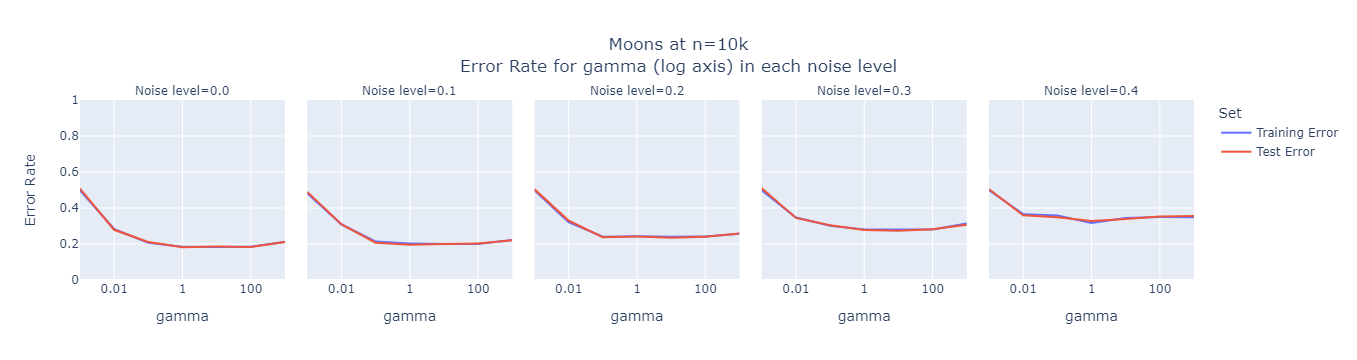

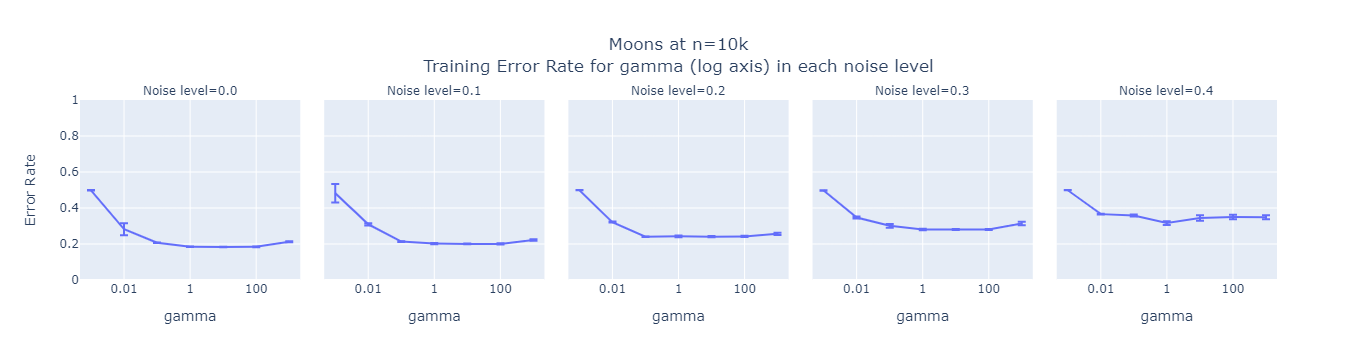

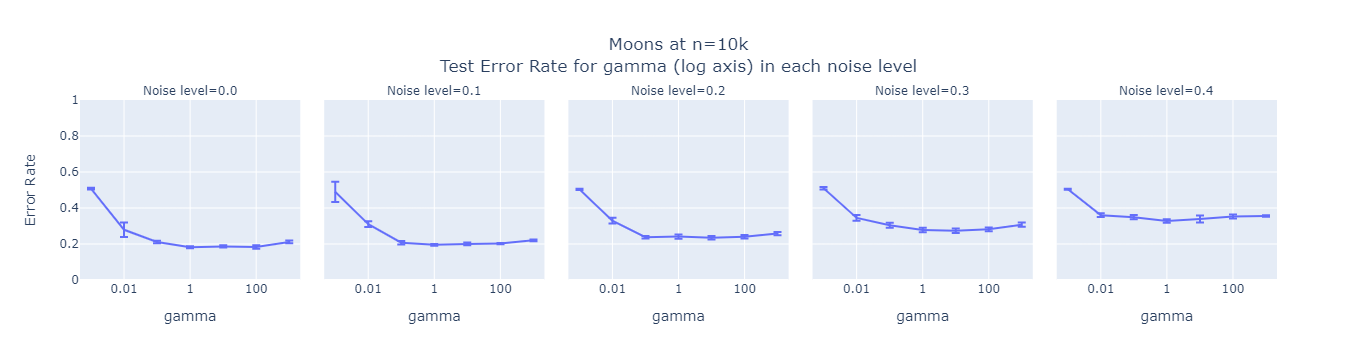

Moons Accuracy


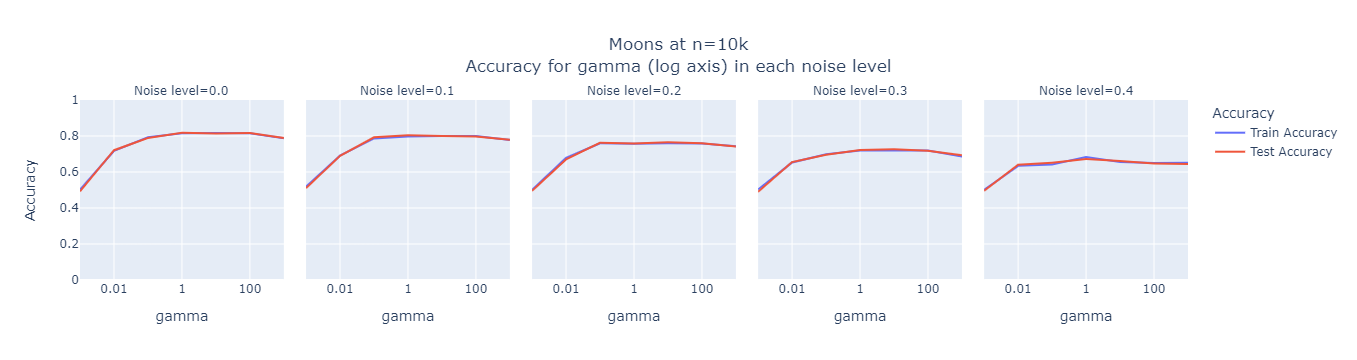

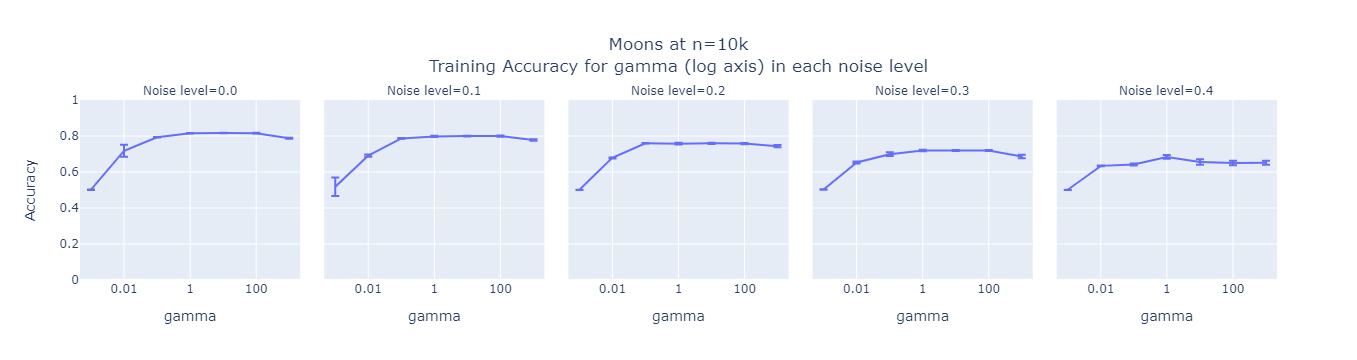

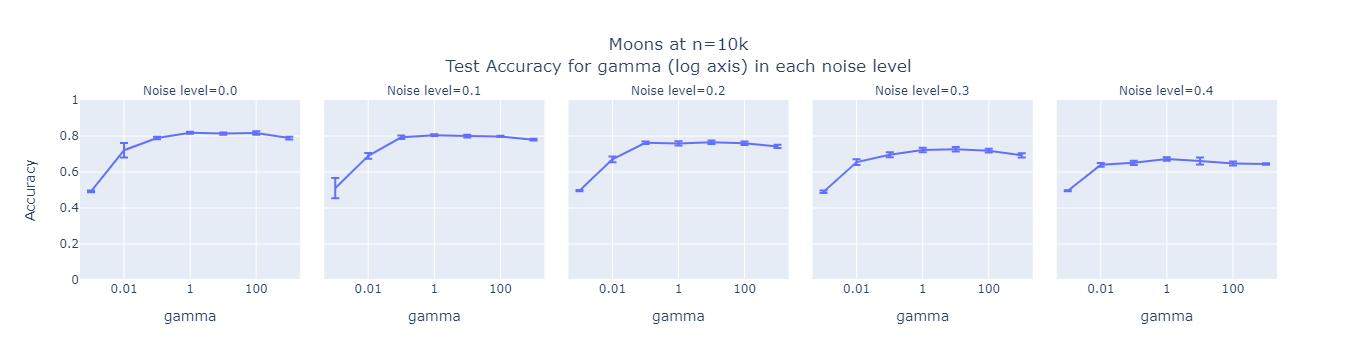

Circles
Circles Error Rate:


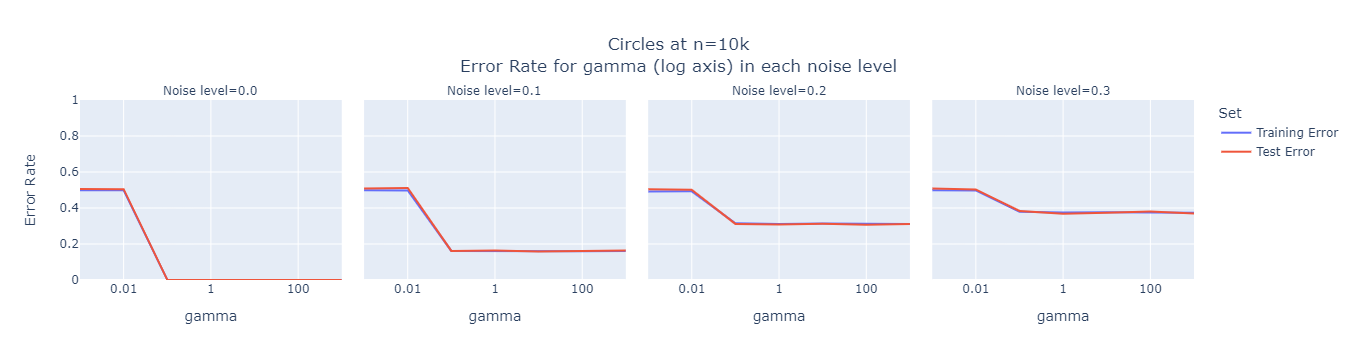

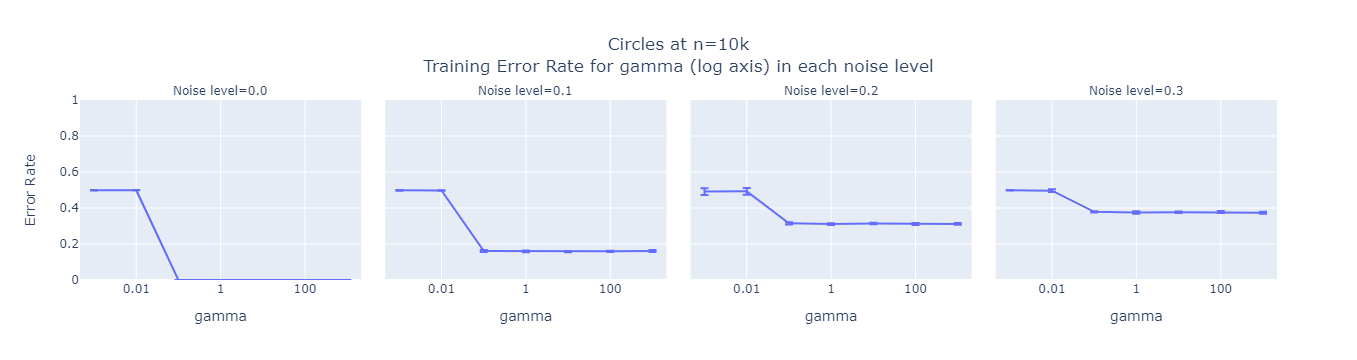

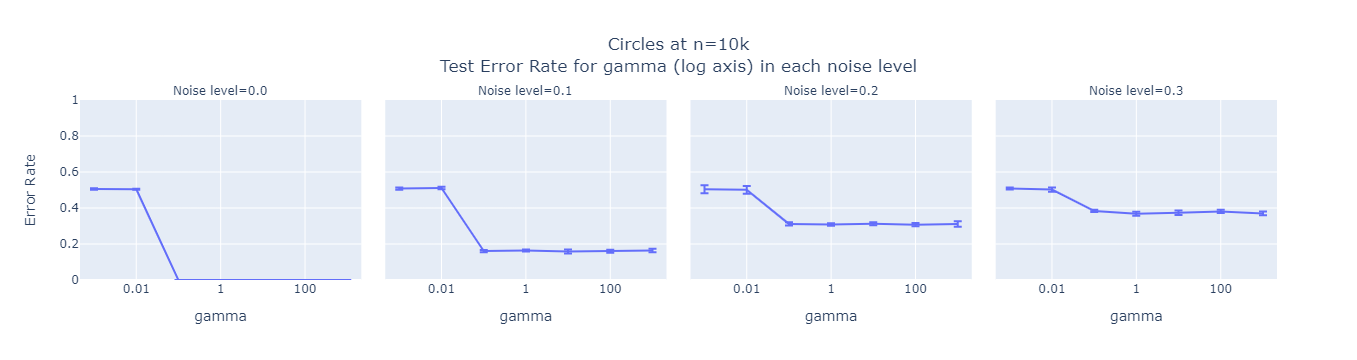

Circles Accuracy


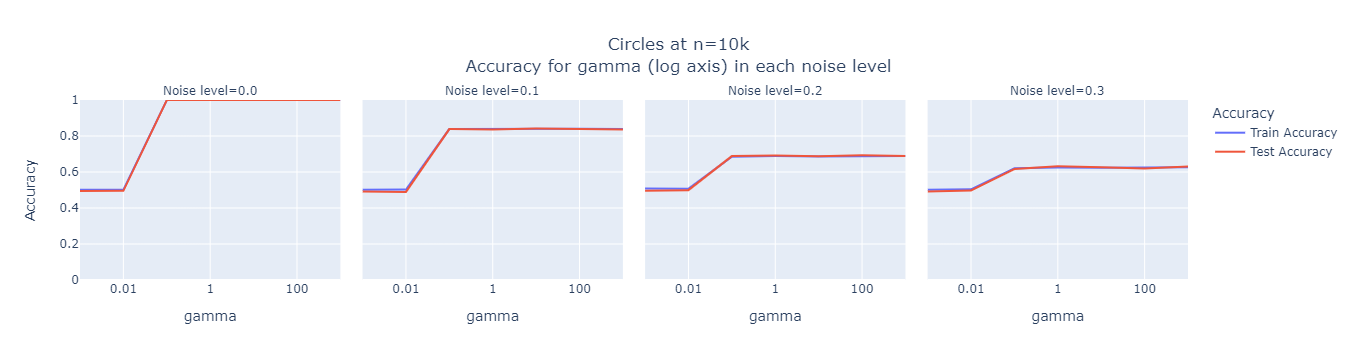

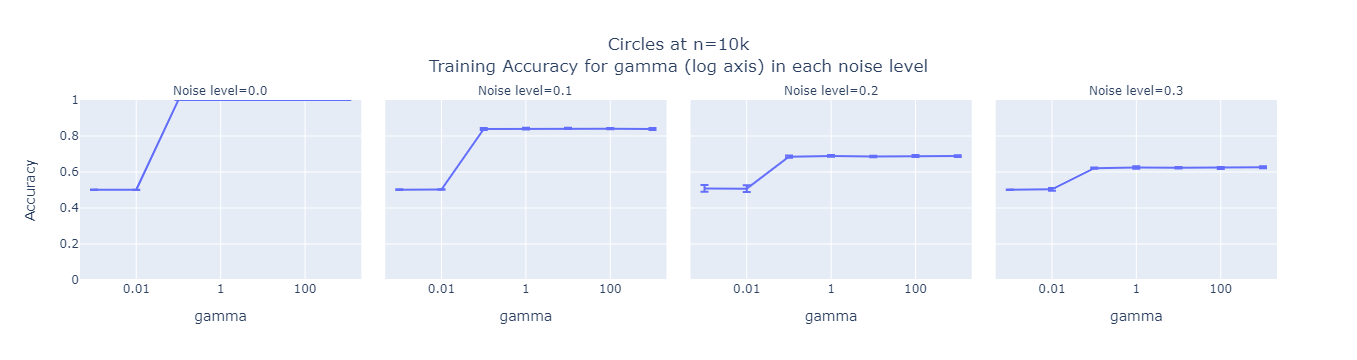

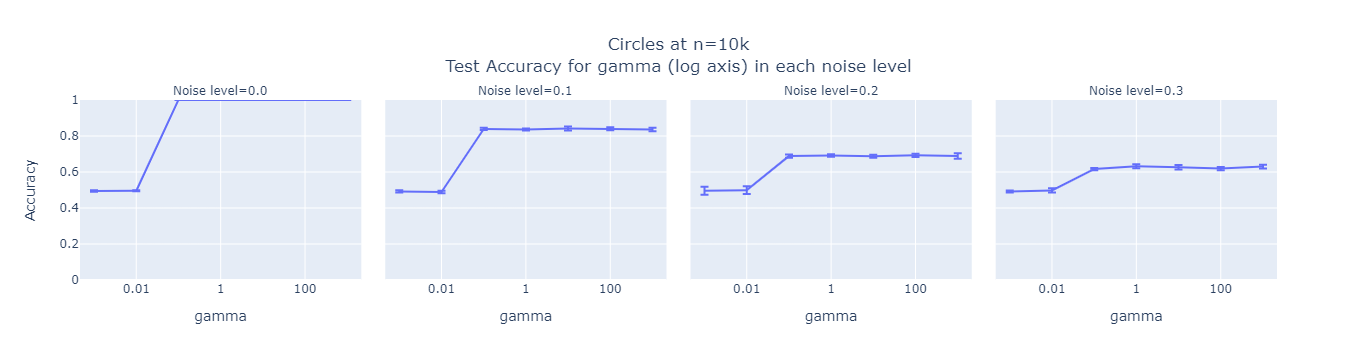

In [23]:
# 1. For SVM only, For dataset of size 10k and for each dataset, What are the best model params? How stable is it?



# Moons
print("Moons")
plot_df = moons_q1.copy()

# Moons Error Rate:
print("Moons Error Rate:")
fig_m1 = px.line(x=plot_df.Hyperparameter, y=[plot_df.TRE_mean, plot_df.TESTE_mean], facet_col=plot_df.NL, log_x=True,
              labels={"x":"gamma", "value":"Error Rate", "facet_col":"Noise level", "variable":"Set"},
              title="Moons at n=10k<br>Error Rate for gamma (log axis) in each noise level")
fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])

newnames = {"wide_variable_0":"Training Error", "wide_variable_1":"Test Error"}
fig_m1.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))
fig_m1.show()



fig_m_train = px.line(x=plot_df.Hyperparameter, y=plot_df.TRE_mean, error_y=plot_df.TRE_std, facet_col=plot_df.NL, log_x=True,
              labels={"x":"gamma", "y":"Error Rate", "facet_col":"Noise level", "variable":"Error Rate"},
              title="Moons at n=10k<br>Training Error Rate for gamma (log axis) in each noise level")
fig_m_train.update_layout(title_x=0.5)
fig_m_train.update_yaxes(range=[0, 1])
fig_m_train.show()

fig_m_test = px.line(x=plot_df.Hyperparameter, y=plot_df.TESTE_mean, error_y=plot_df.TESTE_std, facet_col=plot_df.NL, log_x=True,
              labels={"x":"gamma", "y":"Error Rate", "facet_col":"Noise level", "variable":"Error Rate"},
              title="Moons at n=10k<br>Test Error Rate for gamma (log axis) in each noise level")
fig_m_test.update_layout(title_x=0.5)
fig_m_test.update_yaxes(range=[0, 1])
fig_m_test.show()

# Moons Accuracy:
print("Moons Accuracy")

fig_m1 = px.line(x=plot_df.Hyperparameter, y=[plot_df.TR_ACC_mean, plot_df.TEST_ACC_mean], facet_col=plot_df.NL, log_x=True,
              labels={"x":"gamma", "value":"Accuracy", "facet_col":"Noise level", "variable":"Accuracy"},
              title="Moons at n=10k<br>Accuracy for gamma (log axis) in each noise level")
fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])

newnames = {"wide_variable_0":"Train Accuracy", "wide_variable_1":"Test Accuracy"}
fig_m1.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))
fig_m1.show()



fig_m_train = px.line(x=plot_df.Hyperparameter, y=plot_df.TR_ACC_mean, error_y=plot_df.TR_ACC_std, facet_col=plot_df.NL, log_x=True,
              labels={"x":"gamma", "y":"Accuracy", "facet_col":"Noise level", "variable":"Accuracy"},
              title="Moons at n=10k<br>Training Accuracy for gamma (log axis) in each noise level")
fig_m_train.update_layout(title_x=0.5)
fig_m_train.update_yaxes(range=[0, 1])
fig_m_train.show()

fig_m_test = px.line(x=plot_df.Hyperparameter, y=plot_df.TEST_ACC_mean, error_y=plot_df.TEST_ACC_std, facet_col=plot_df.NL, log_x=True,
              labels={"x":"gamma", "y":"Accuracy", "facet_col":"Noise level", "variable":"Accuracy"},
              title="Moons at n=10k<br>Test Accuracy for gamma (log axis) in each noise level")
fig_m_test.update_layout(title_x=0.5)
fig_m_test.update_yaxes(range=[0, 1])
fig_m_test.show()

# Circles
ds = "Circles"
print(ds)
plot_df = circles_q1.copy()

# Error Rate:
print(f"{ds} Error Rate:")
fig_m1 = px.line(x=plot_df.Hyperparameter, y=[plot_df.TRE_mean, plot_df.TESTE_mean], facet_col=plot_df.NL, log_x=True,
              labels={"x":"gamma", "value":"Error Rate", "facet_col":"Noise level", "variable":"Set"},
              title=f"{ds} at n=10k<br>Error Rate for gamma (log axis) in each noise level")
fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])

newnames = {"wide_variable_0":"Training Error", "wide_variable_1":"Test Error"}
fig_m1.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))
fig_m1.show()



fig_m_train = px.line(x=plot_df.Hyperparameter, y=plot_df.TRE_mean, error_y=plot_df.TRE_std, facet_col=plot_df.NL, log_x=True,
              labels={"x":"gamma", "y":"Error Rate", "facet_col":"Noise level", "variable":"Error Rate"},
              title=f"{ds} at n=10k<br>Training Error Rate for gamma (log axis) in each noise level")
fig_m_train.update_layout(title_x=0.5)
fig_m_train.update_yaxes(range=[0, 1])
fig_m_train.show()

fig_m_test = px.line(x=plot_df.Hyperparameter, y=plot_df.TESTE_mean, error_y=plot_df.TESTE_std, facet_col=plot_df.NL, log_x=True,
              labels={"x":"gamma", "y":"Error Rate", "facet_col":"Noise level", "variable":"Error Rate"},
              title=f"{ds} at n=10k<br>Test Error Rate for gamma (log axis) in each noise level")
fig_m_test.update_layout(title_x=0.5)
fig_m_test.update_yaxes(range=[0, 1])
fig_m_test.show()

# Accuracy:
print(f"{ds} Accuracy")

fig_m1 = px.line(x=plot_df.Hyperparameter, y=[plot_df.TR_ACC_mean, plot_df.TEST_ACC_mean], facet_col=plot_df.NL, log_x=True,
              labels={"x":"gamma", "value":"Accuracy", "facet_col":"Noise level", "variable":"Accuracy"},
              title=f"{ds} at n=10k<br>Accuracy for gamma (log axis) in each noise level")
fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])

newnames = {"wide_variable_0":"Train Accuracy", "wide_variable_1":"Test Accuracy"}
fig_m1.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))
fig_m1.show()



fig_m_train = px.line(x=plot_df.Hyperparameter, y=plot_df.TR_ACC_mean, error_y=plot_df.TR_ACC_std, facet_col=plot_df.NL, log_x=True,
              labels={"x":"gamma", "y":"Accuracy", "facet_col":"Noise level", "variable":"Accuracy"},
              title=f"{ds} at n=10k<br>Training Accuracy for gamma (log axis) in each noise level")
fig_m_train.update_layout(title_x=0.5)
fig_m_train.update_yaxes(range=[0, 1])
fig_m_train.show()

fig_m_test = px.line(x=plot_df.Hyperparameter, y=plot_df.TEST_ACC_mean, error_y=plot_df.TEST_ACC_std, facet_col=plot_df.NL, log_x=True,
              labels={"x":"gamma", "y":"Accuracy", "facet_col":"Noise level", "variable":"Accuracy"},
              title=f"{ds} at n=10k<br>Test Accuracy for gamma (log axis) in each noise level")
fig_m_test.update_layout(title_x=0.5)
fig_m_test.update_yaxes(range=[0, 1])
fig_m_test.show()

In [24]:
print("Answer to Q1:")
print("Since The Accuracy reaches a plateau around gamma=0.1, I would suggest considering gamma=1 as the parameter of choice.\nIt is extremely stable with a very small standard deviation.")

Answer to Q1:
Since The Accuracy reaches a plateau around gamma=0.1, I would suggest considering gamma=1 as the parameter of choice.
It is extremely stable with a very small standard deviation.


Q 2. For SVM only, For dataset of size 10k and for each dataset, What is the most stable model and model params? How good is it in comparison to other models? Explain using bias and variance terminoligy.

In [25]:
print("Answer to Q2:")
print("All of the models (in SVM, N=10K) seem to have a small variance, and so do not seem to overfit the training set (That said, the test set is actually a validation set, and not a separate set with completely 'new' data.)")
print("However, there is a significant amount of bias, which worsens with the addition of more Noise.")

Answer to Q2:
All of the models (in SVM, N=10K) seem to have a small variance, and so do not seem to overfit the training set (That said, the test set is actually a validation set, and not a separate set with completely 'new' data.)
However, there is a significant amount of bias, which worsens with the addition of more Noise.


Q 3. Does regularization help for linear models? consider different datasets sizes. 

In [26]:
df=df_k.copy().reset_index()
df = df[df.CLF_NAME=="LogisticRegression"]
# display(df.head())

moons_q3 = df.loc[df.DS_NAME=="Moons",:]
moons_q3 = moons_q3.reset_index(drop=True)
moons_q3 = moons_q3.sort_values(by=["NL","Hyperparameter"])

circles_q3 = df.loc[df.DS_NAME=="Circles",:]
circles_q3 = circles_q3.reset_index(drop=True)
circles_q3 = circles_q3.sort_values(by=["NL","Hyperparameter"])

# moons_q3

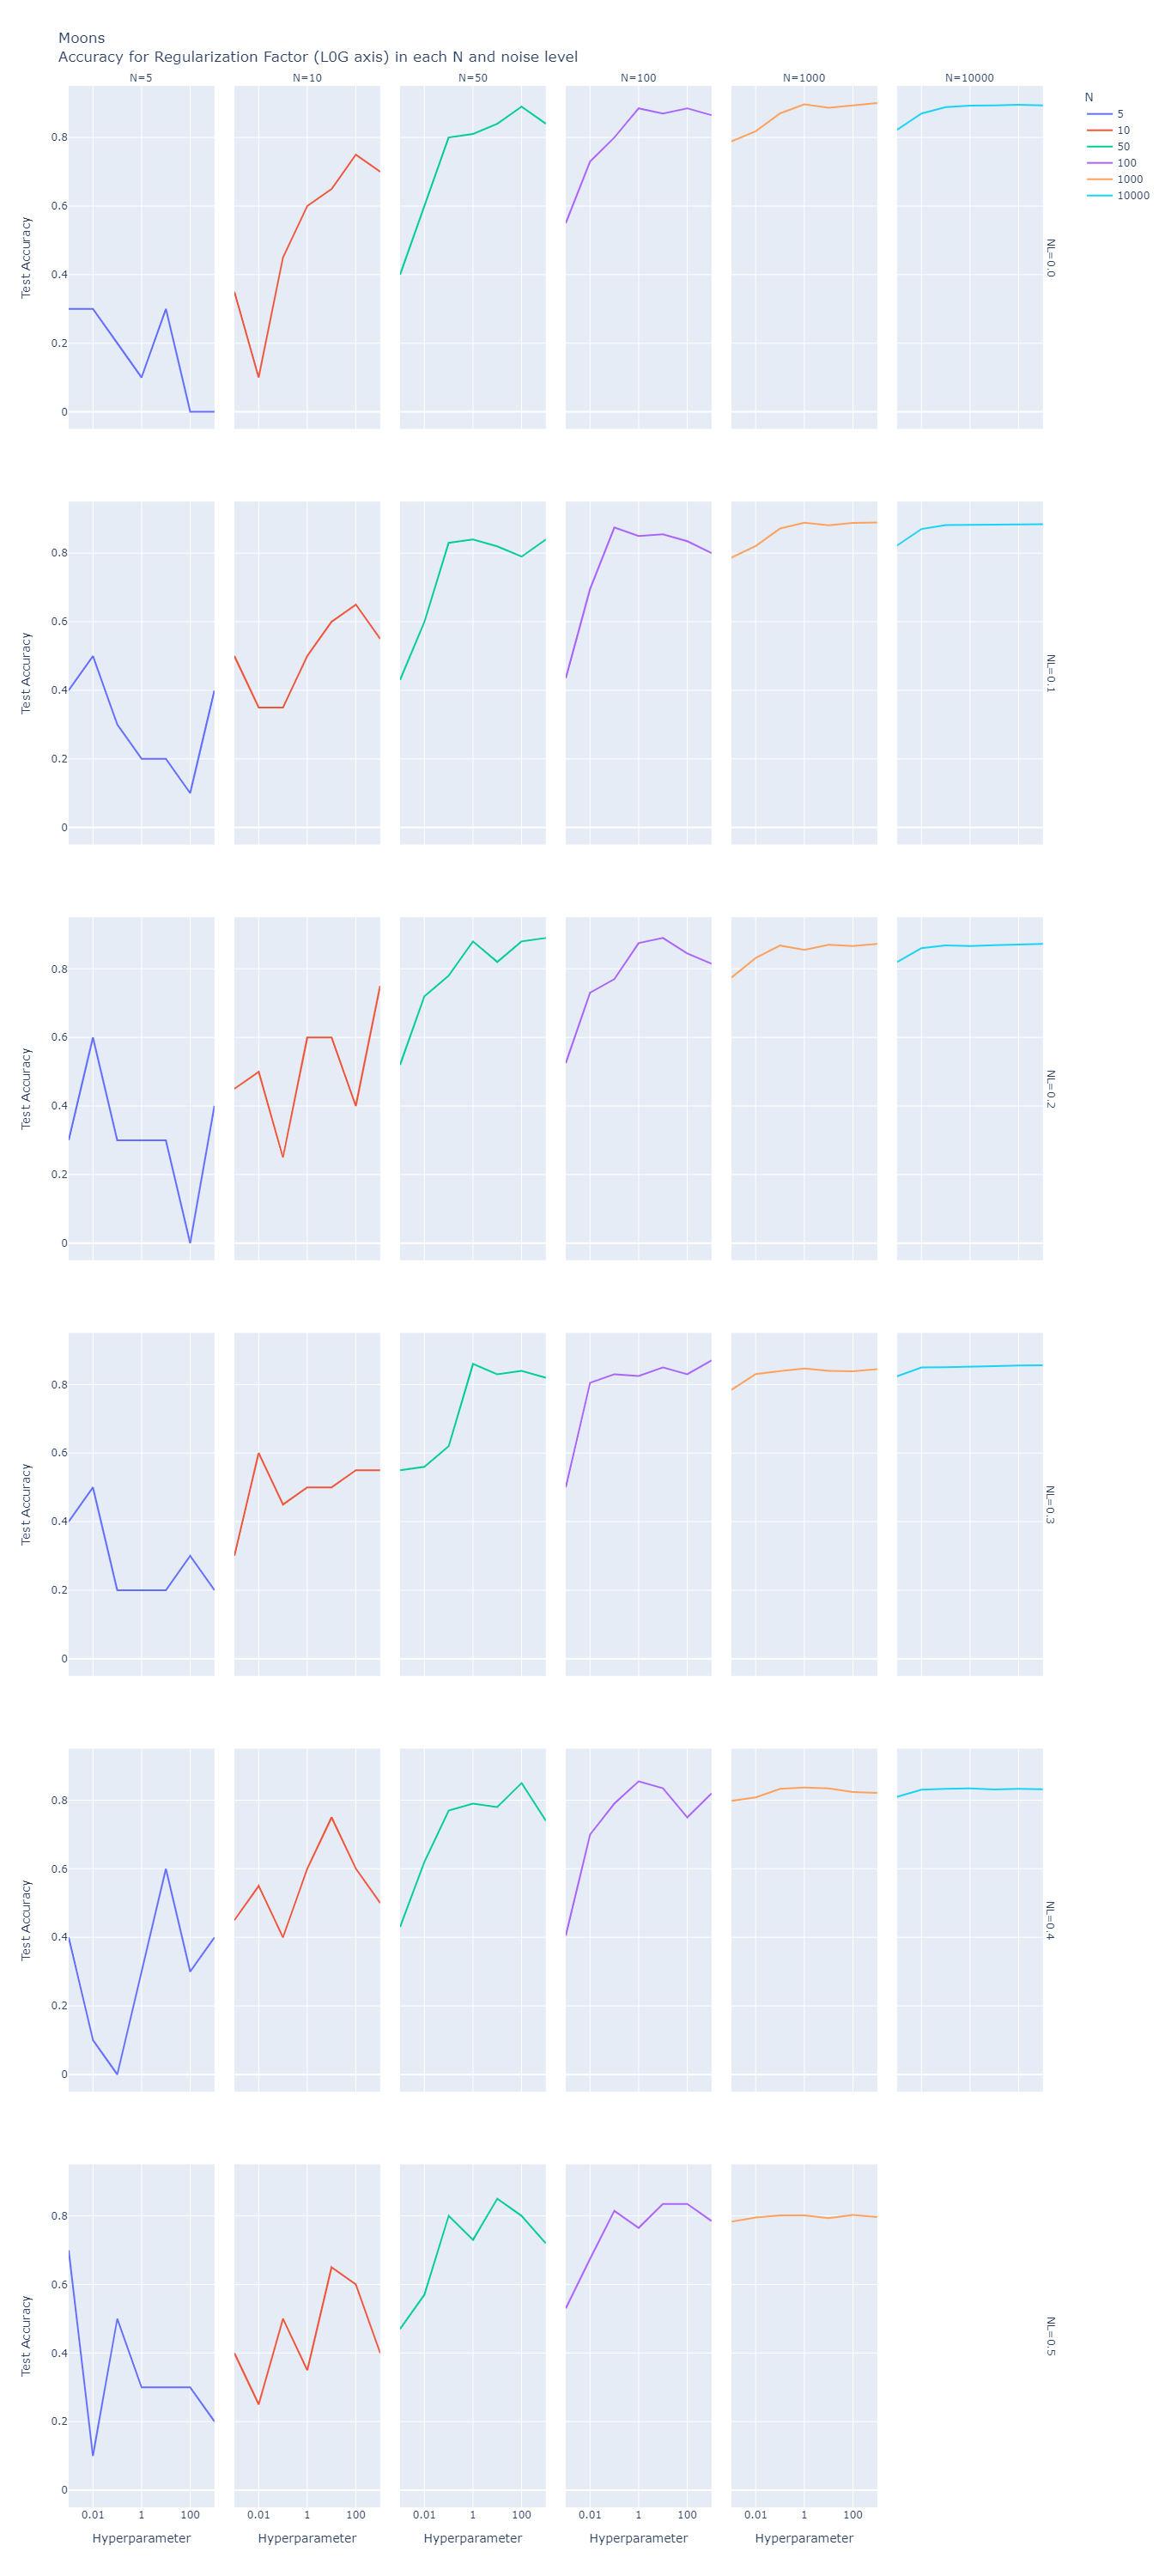

In [27]:
ds = "Moons"
plot_df = moons_q3.copy()
fig = px.line(data_frame=plot_df, x=plot_df.Hyperparameter, y=plot_df.TEST_ACC_mean, facet_row=plot_df.NL, facet_col=plot_df.N, color=plot_df.N, log_x=True, height=3000,
              title=f"{ds}<br>Accuracy for Regularization Factor (L0G axis) in each N and noise level",
             labels={"TEST_ACC_mean":"Test Accuracy"})
# labels={"x":"gamma", "value":"Error Rate", "facet_col":"Noise level", "variable":"Set"},
fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])
fig.show()

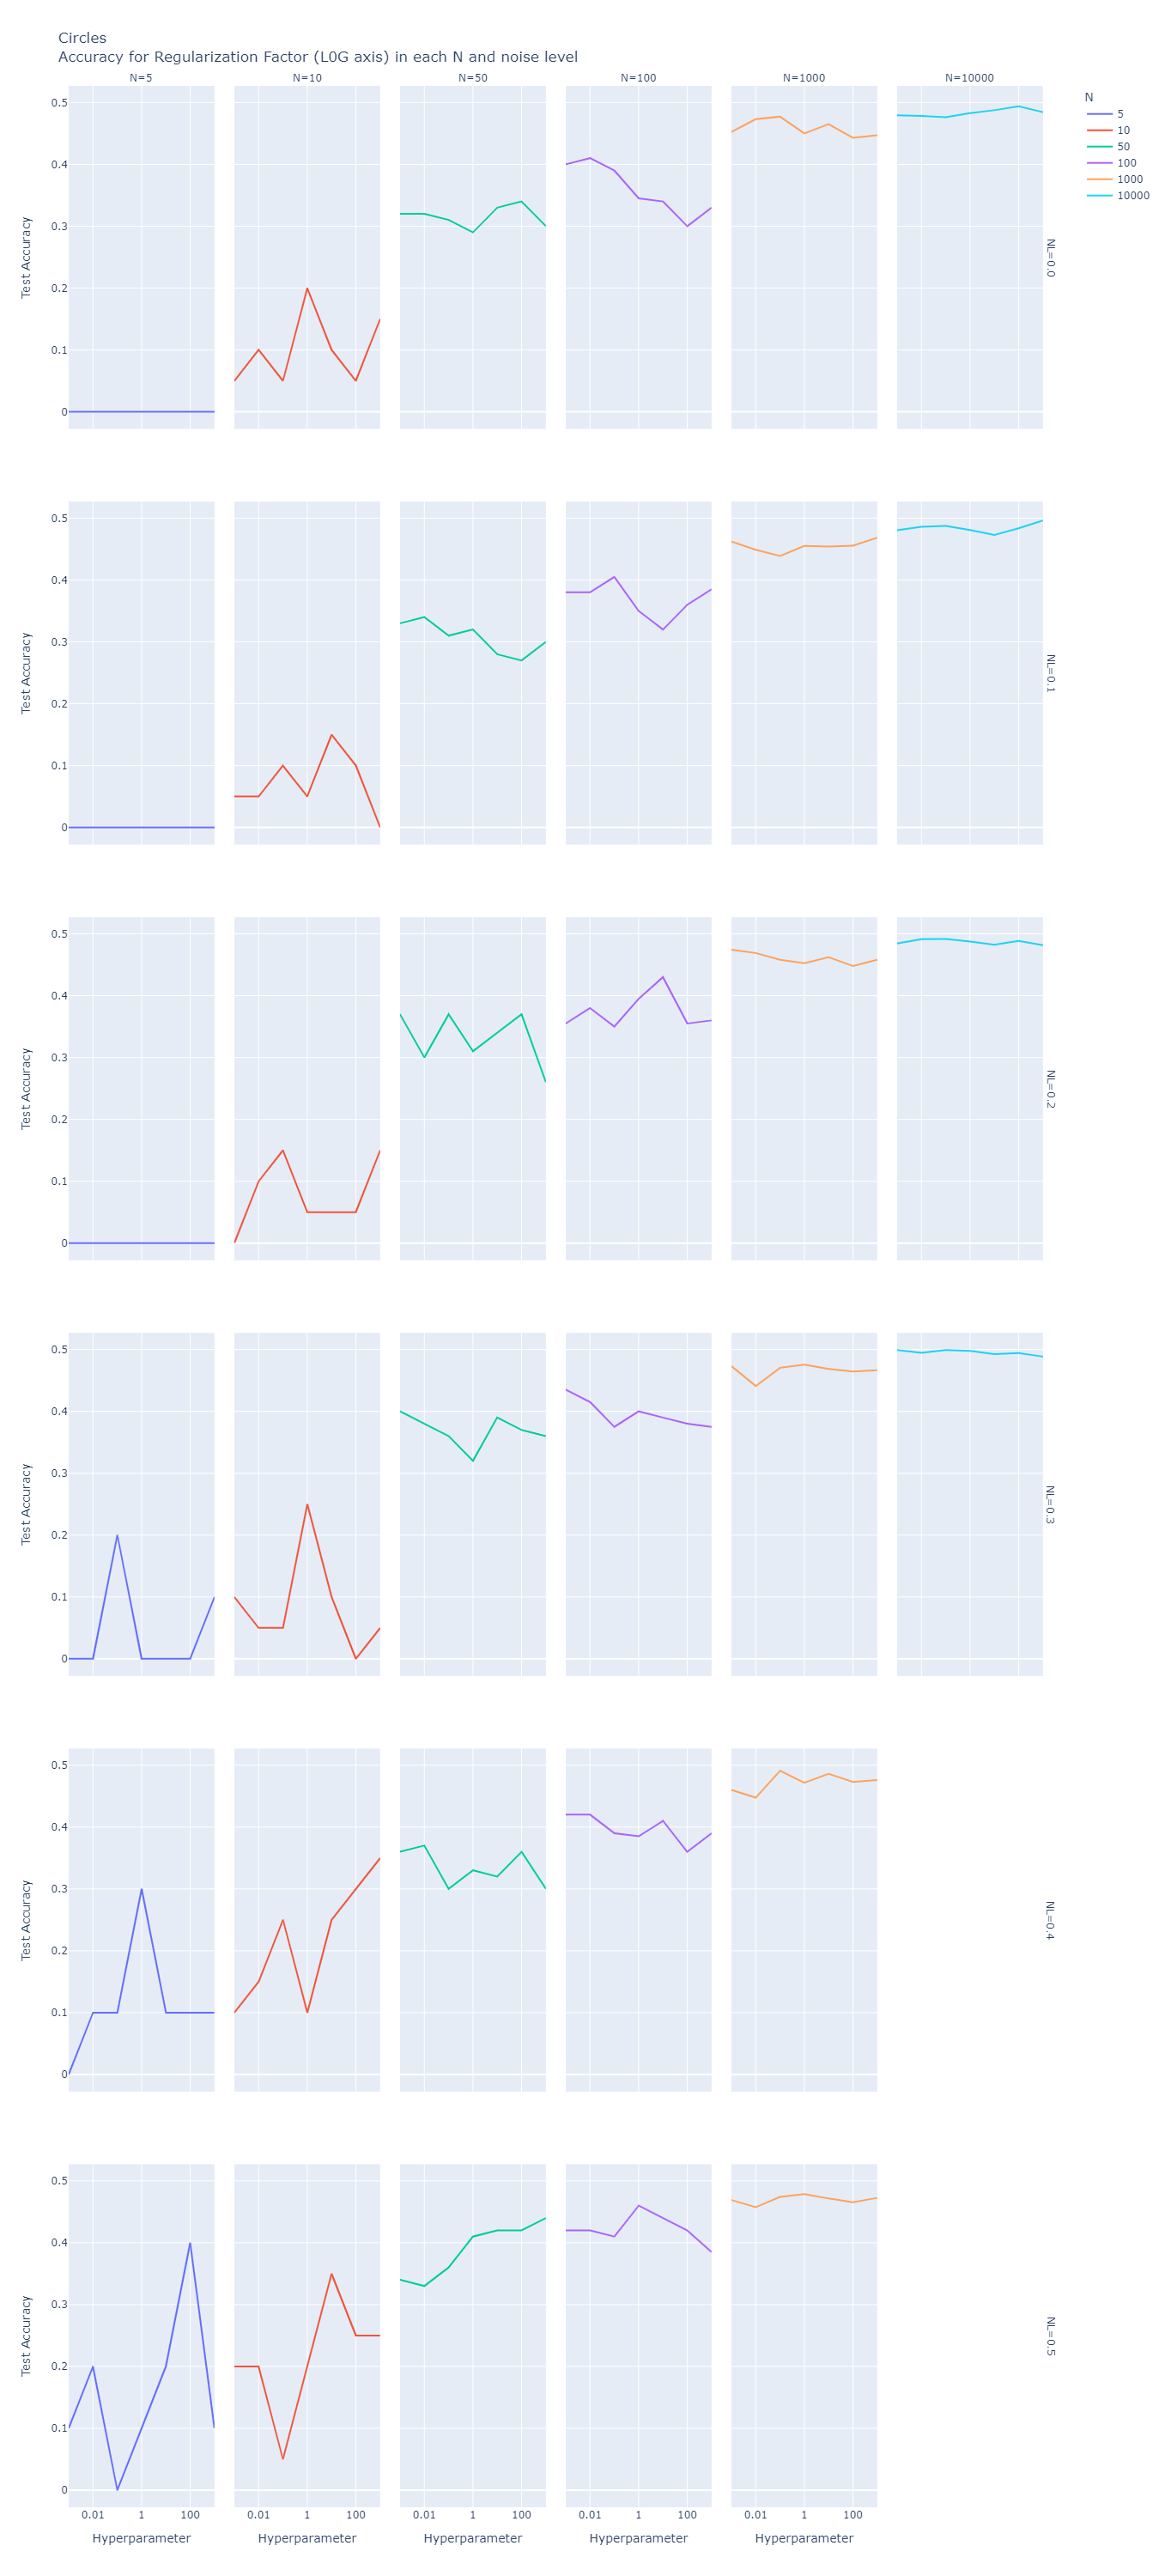

In [28]:
ds = "Circles"
plot_df = circles_q3.copy()
fig = px.line(data_frame=plot_df, x=plot_df.Hyperparameter, y=plot_df.TEST_ACC_mean, facet_row=plot_df.NL, facet_col=plot_df.N, color=plot_df.N, log_x=True, height=3000,
              title=f"{ds}<br>Accuracy for Regularization Factor (L0G axis) in each N and noise level",
             labels={"TEST_ACC_mean":"Test Accuracy"})

fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])
fig.show()

In [29]:
print("""
Answer to Q3.
The case of N=5 acts as an outlier. Its behavior is understandably unpredictable.
Otherwise, for the Moons dataset, regularization seems to help in all of the cases, until a certain point where it either reaches a plateau, or even starts to negatively affect the Accuracy measured for the test set.
As for the Circles dataset - Regularization does not seem to cause any PERSISTENT pattern.
""")


Answer to Q3.
The case of N=5 acts as an outlier. Its behavior is understandably unpredictable.
Otherwise, for the Moons dataset, regularization seems to help in all of the cases, until a certain point where it either reaches a plateau, or even starts to negatively affect the Accuracy measured for the test set.
As for the Circles dataset - Regularization does not seem to cause any PERSISTENT pattern.



4. For a given noise level of your chioce, How does the train, test and difference error changes with increasing data sizes? (answer for svm and LR seperatly)

Logistic Regression
Moons


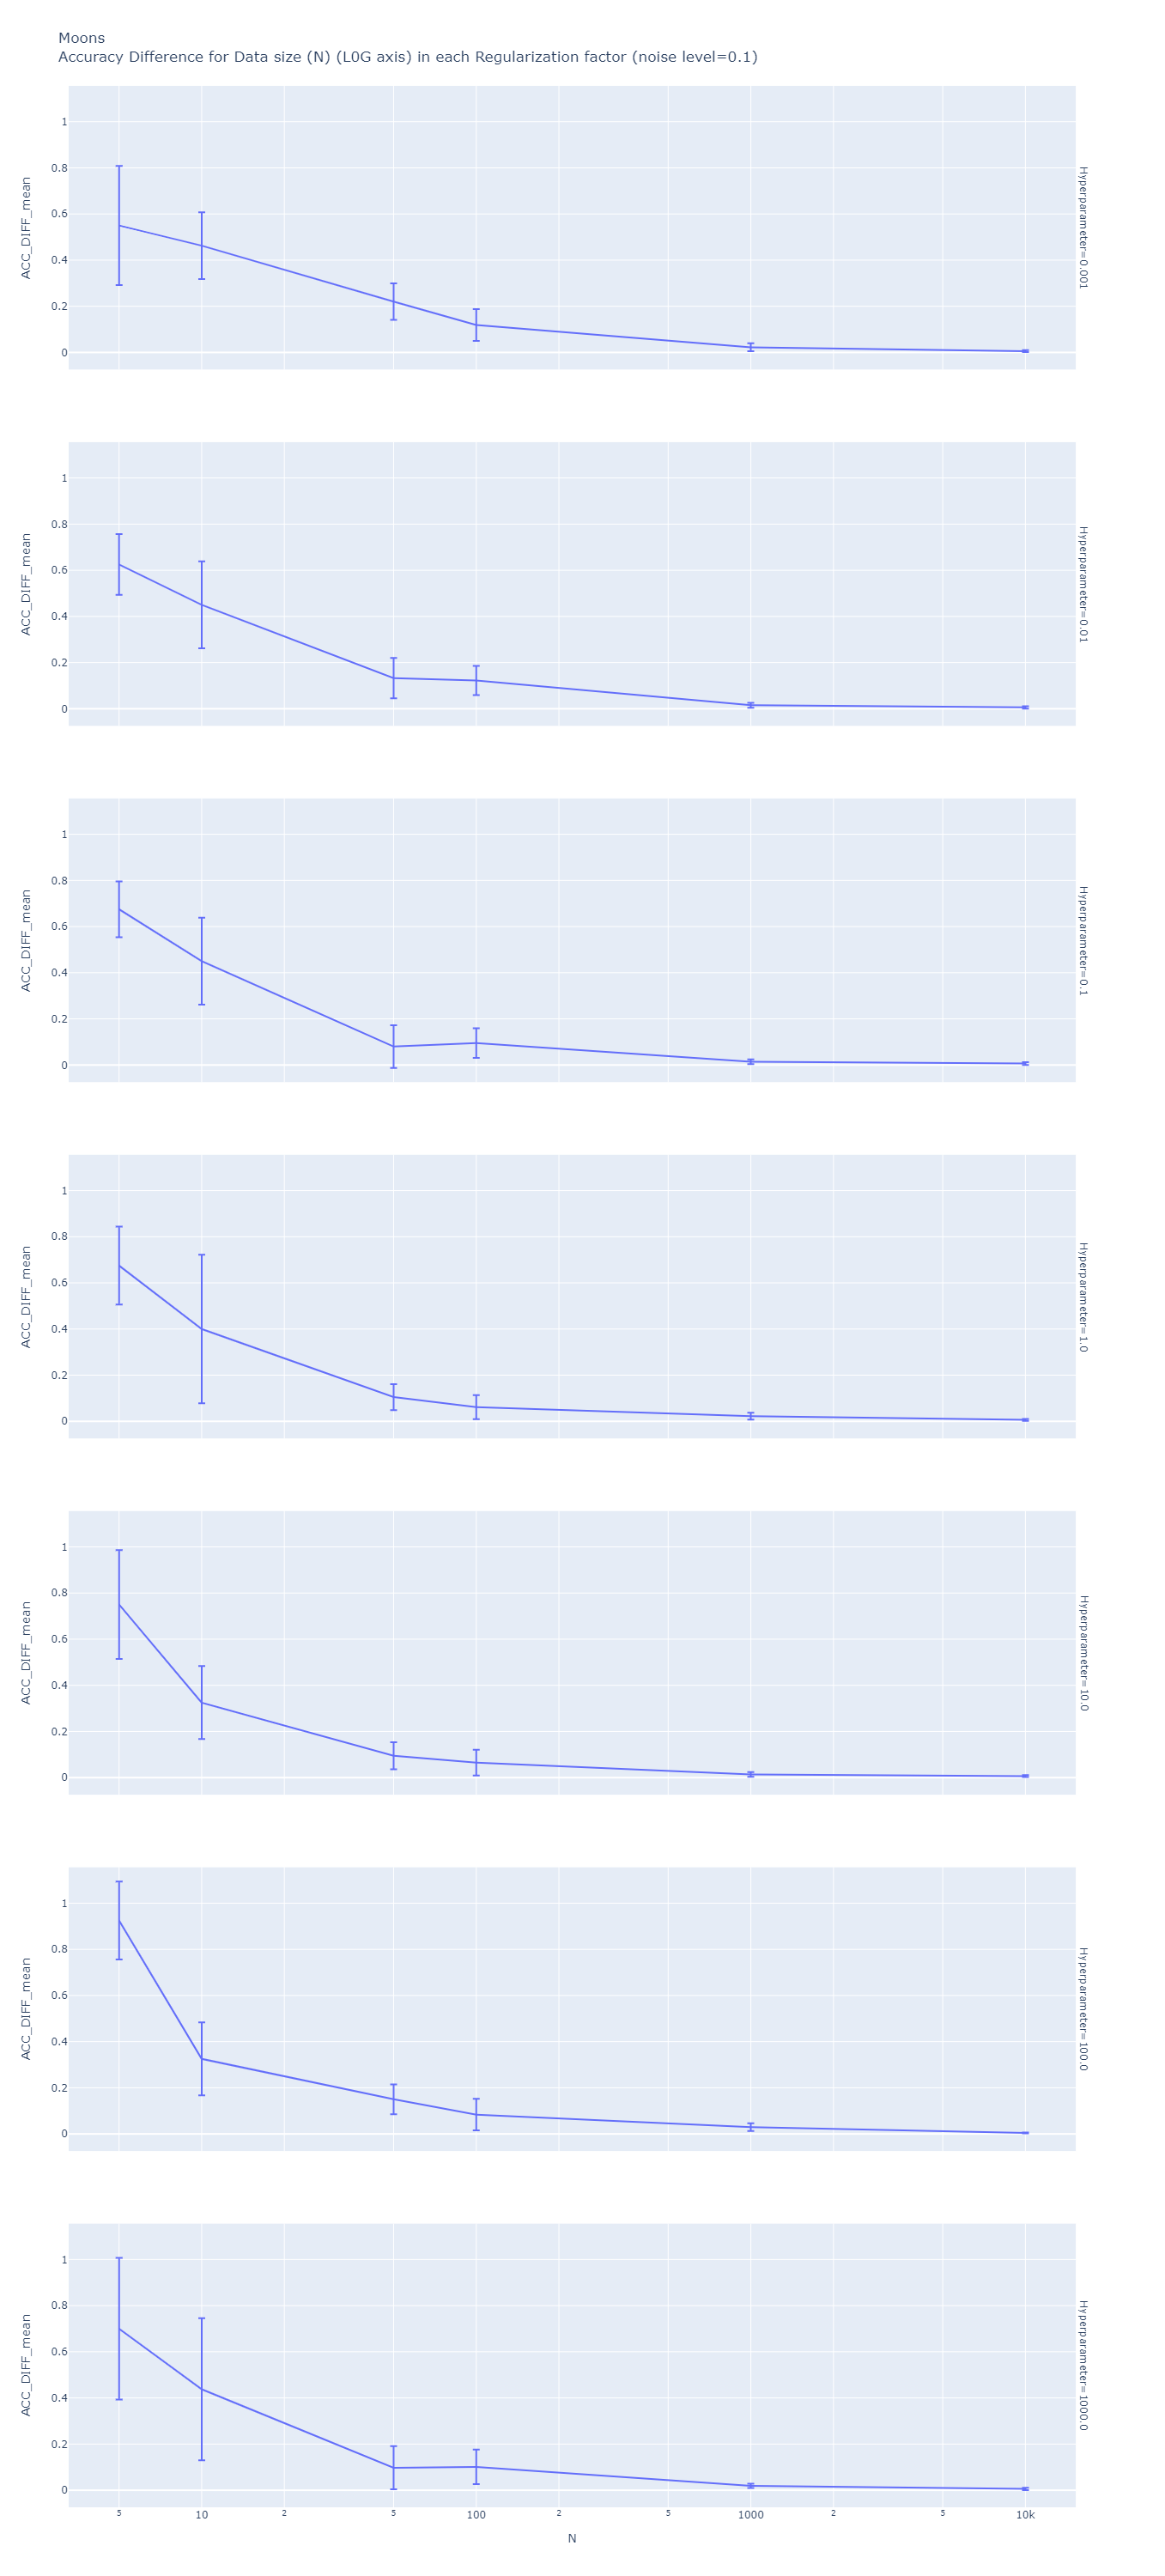

Circles


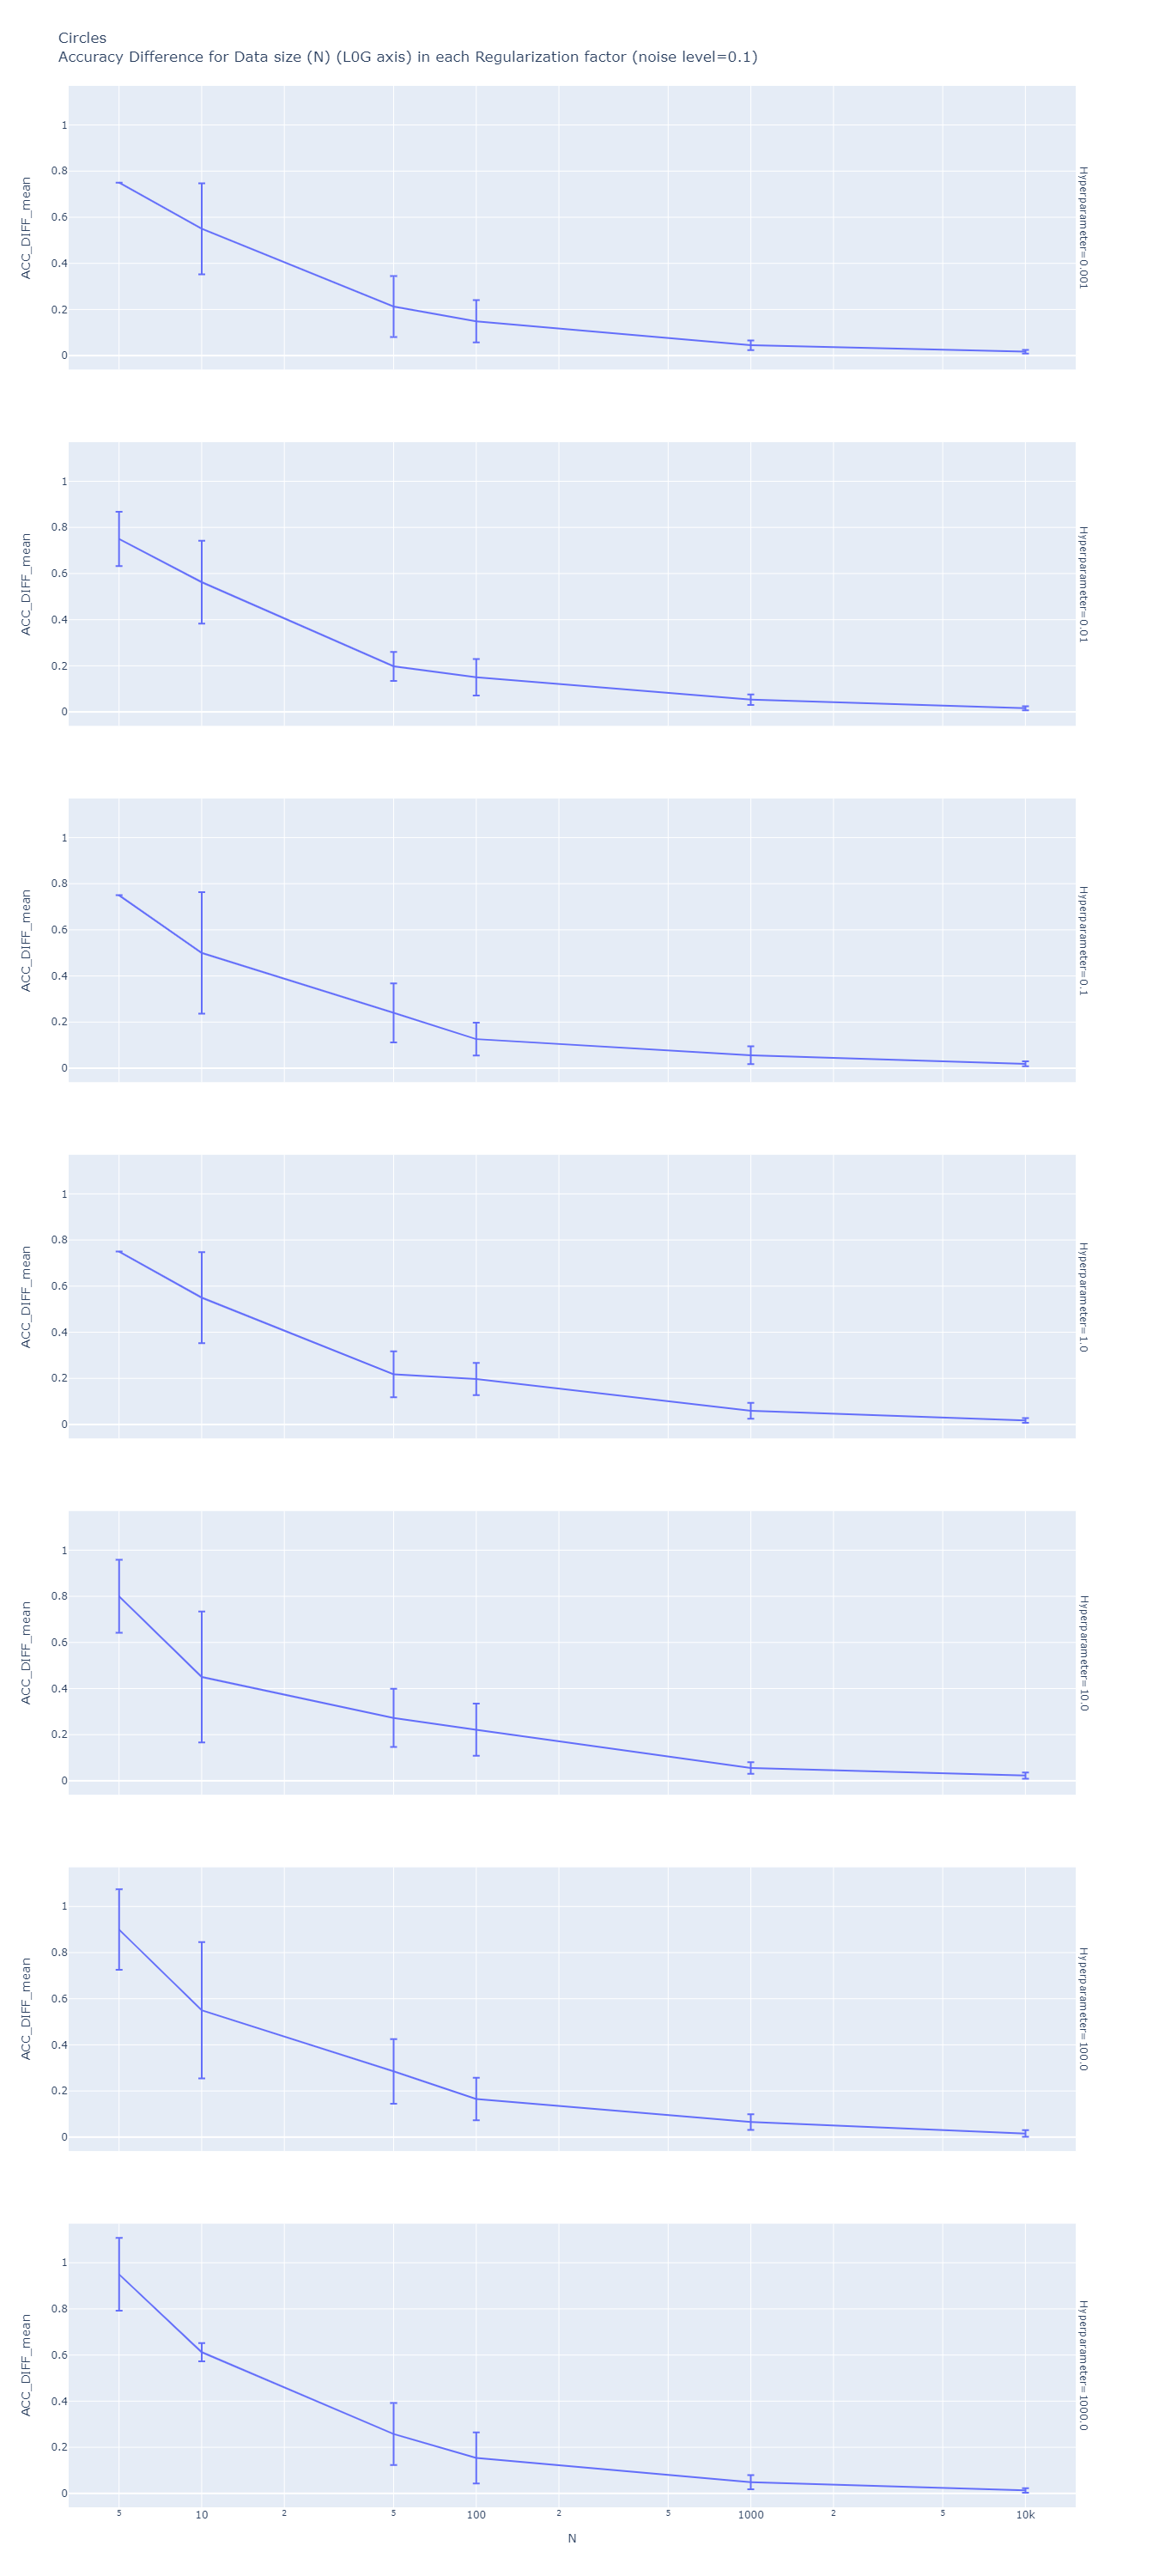

In [30]:
print("Logistic Regression")
df=df_k.copy().reset_index()
df = df[(df.CLF_NAME=="LogisticRegression") & (df.NL==0.1)]


moons_q4 = df.loc[df.DS_NAME=="Moons",:]
moons_q4 = moons_q4.reset_index(drop=True)
moons_q4 = moons_q4.sort_values(by=["NL","Hyperparameter"])

ds = "Moons"
plot_df = moons_q4.copy()
print(ds)
fig = px.line(data_frame=plot_df, x=plot_df.N, y=plot_df.ACC_DIFF_mean, error_y=plot_df.ACC_DIFF_std, facet_row=plot_df.Hyperparameter, facet_col=None, color=None, log_x=True, height=3000,
              title=f"{ds}<br>Accuracy Difference for Data size (N) (L0G axis) in each Regularization factor (noise level=0.1)",
             labels={"TEST_ACC_mean":"Test Accuracy"})
fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])
fig.show()


circles_q4 = df.loc[df.DS_NAME=="Circles",:]
circles_q4 = circles_q4.reset_index(drop=True)
circles_q4 = circles_q4.sort_values(by=["NL","Hyperparameter"])

ds = "Circles"
plot_df = circles_q4.copy()
print(ds)
fig = px.line(data_frame=plot_df, x=plot_df.N, y=plot_df.ACC_DIFF_mean, error_y=plot_df.ACC_DIFF_std,facet_row=plot_df.Hyperparameter, facet_col=None, color=None, log_x=True, height=3000,
              title=f"{ds}<br>Accuracy Difference for Data size (N) (L0G axis) in each Regularization factor (noise level=0.1)",
             labels={"TEST_ACC_mean":"Test Accuracy"})
fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])
fig.show()

SVM
Moons


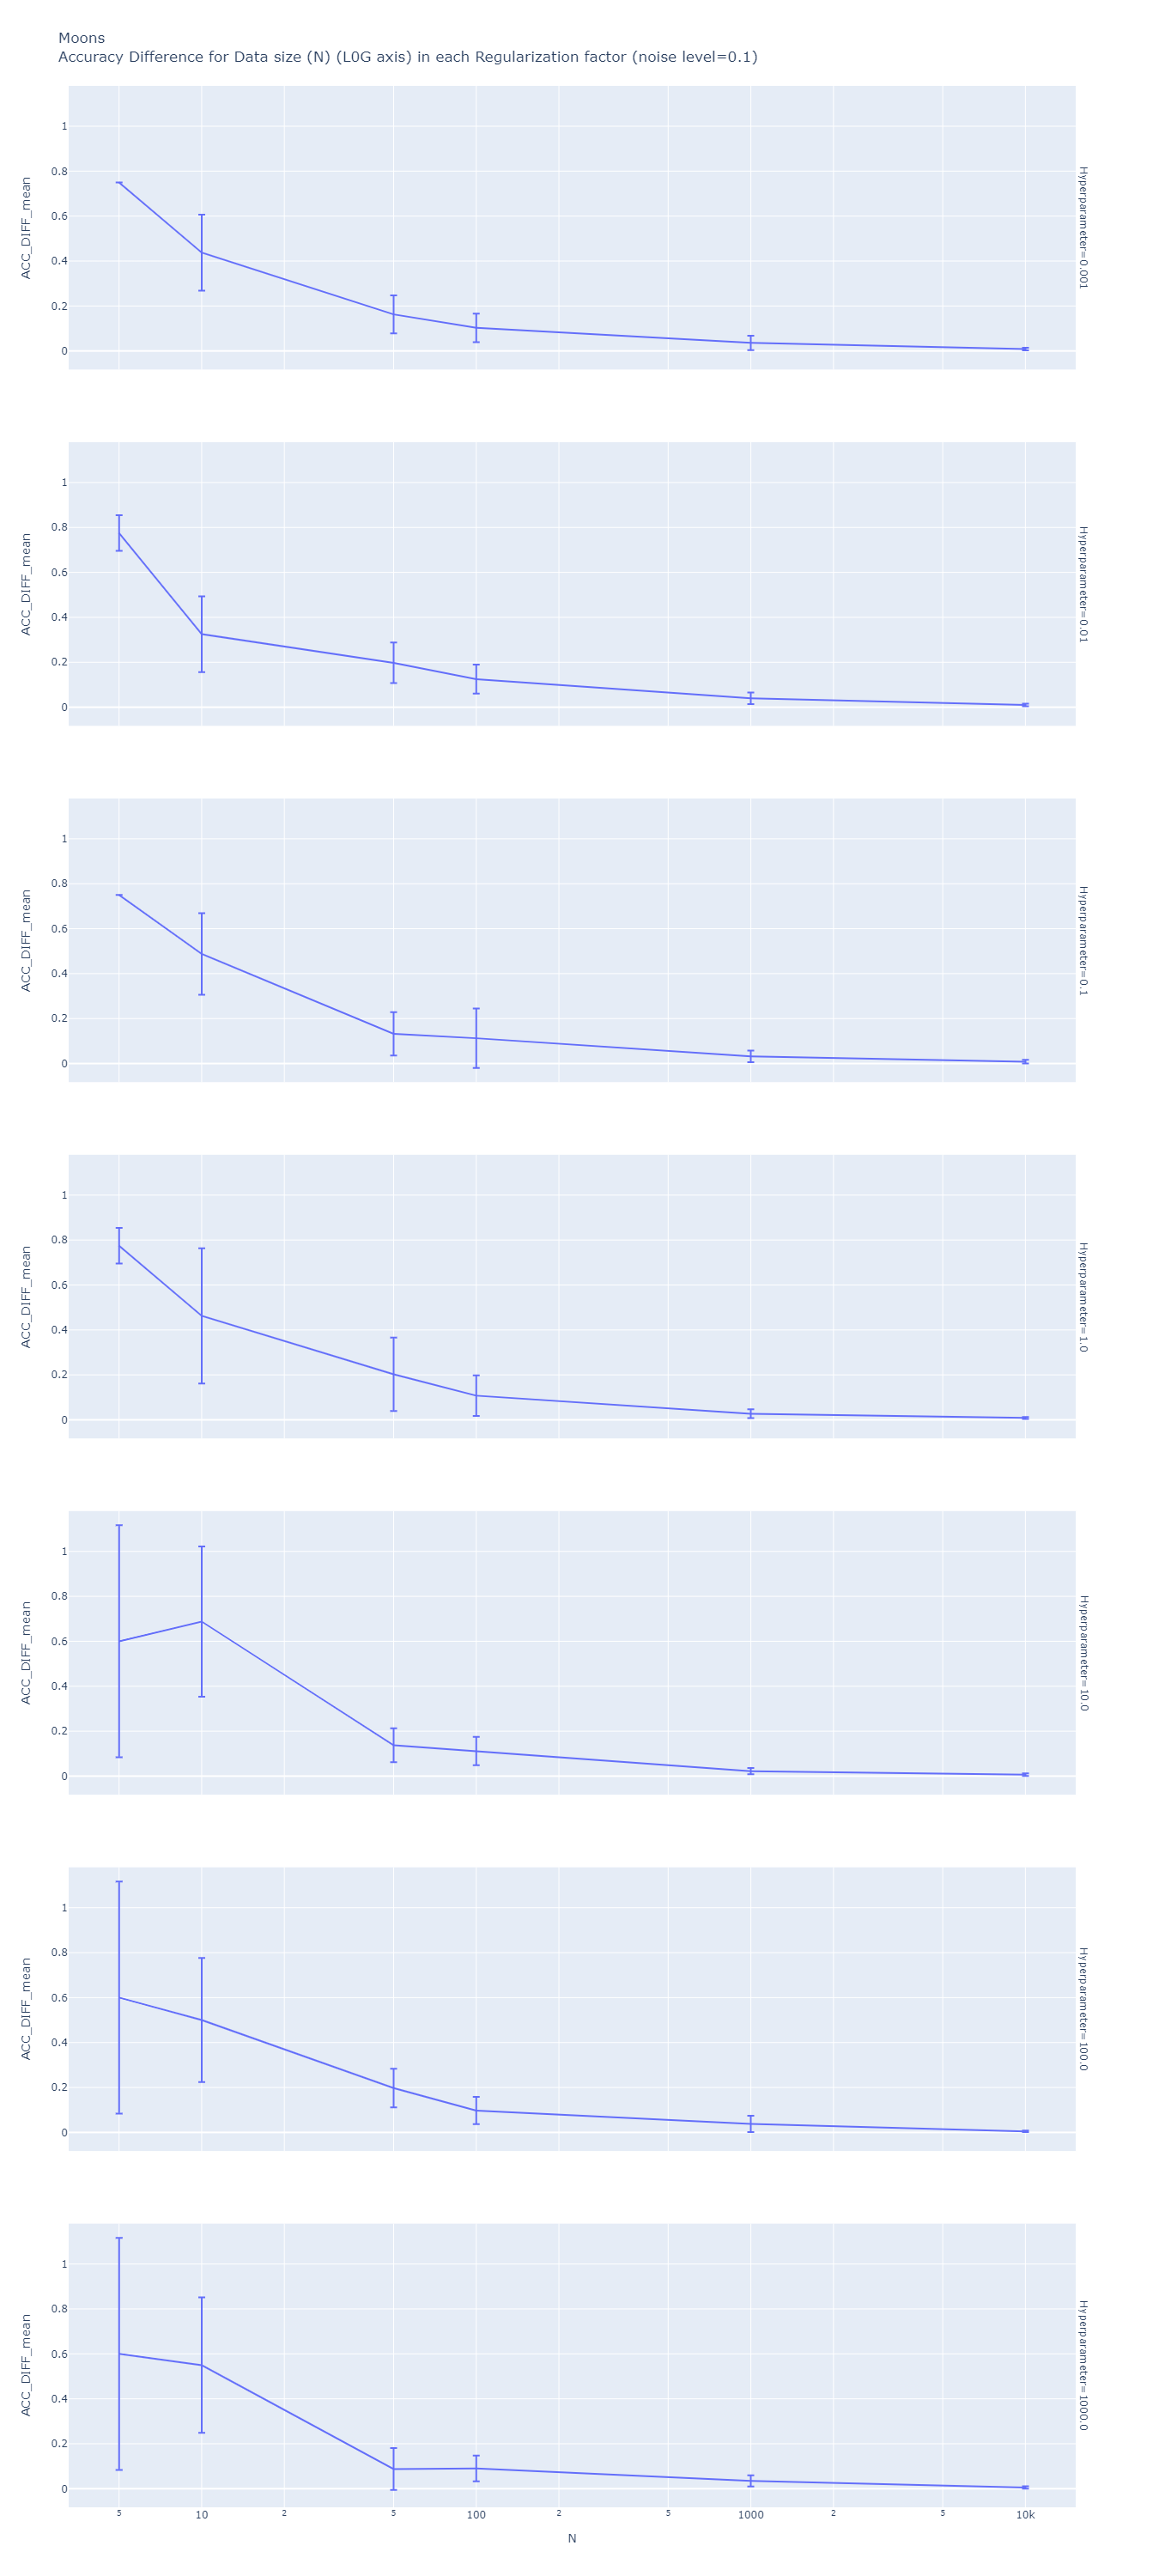

Circles


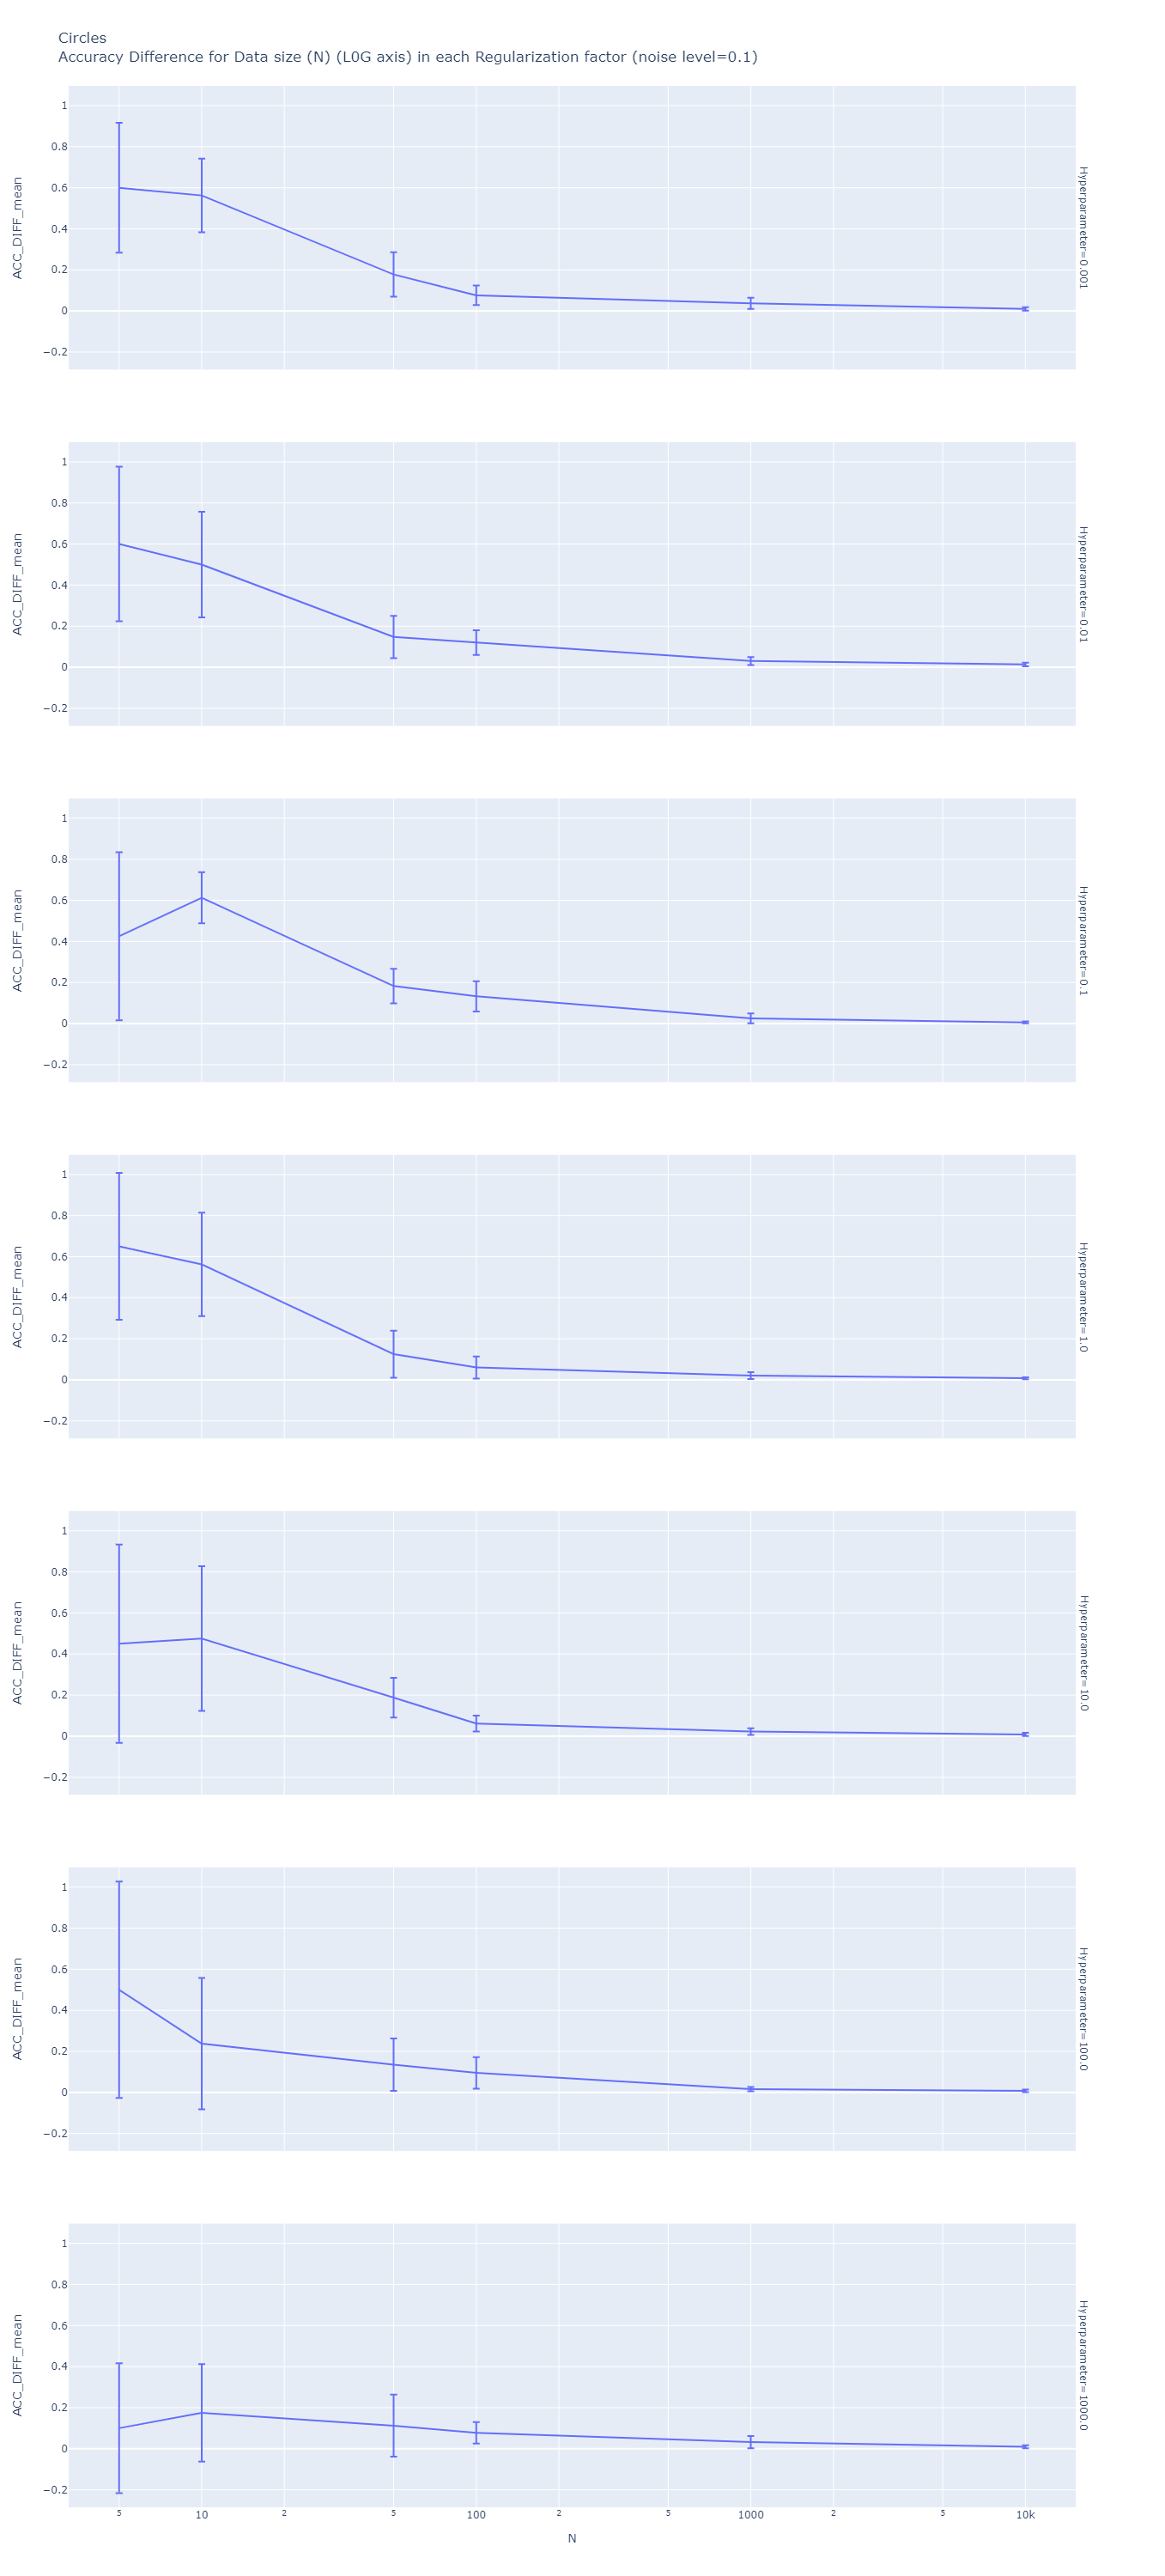

In [31]:
print("SVM")
df=df_k.copy().reset_index()
df = df[(df.CLF_NAME=="SVM") & (df.NL==0.1)]


moons_q4 = df.loc[df.DS_NAME=="Moons",:]
moons_q4 = moons_q4.reset_index(drop=True)
moons_q4 = moons_q4.sort_values(by=["NL","Hyperparameter"])

ds = "Moons"
plot_df = moons_q4.copy()
print(ds)
fig = px.line(data_frame=plot_df, x=plot_df.N, y=plot_df.ACC_DIFF_mean,error_y=plot_df.ACC_DIFF_std, facet_row=plot_df.Hyperparameter, facet_col=None, color=None, log_x=True, height=3000,
              title=f"{ds}<br>Accuracy Difference for Data size (N) (L0G axis) in each Regularization factor (noise level=0.1)",
             labels={"TEST_ACC_mean":"Test Accuracy"})
fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])
fig.show()


circles_q4 = df.loc[df.DS_NAME=="Circles",:]
circles_q4 = circles_q4.reset_index(drop=True)
circles_q4 = circles_q4.sort_values(by=["NL","Hyperparameter"])

ds = "Circles"
plot_df = circles_q4.copy()
print(ds)
fig = px.line(data_frame=plot_df, x=plot_df.N, y=plot_df.ACC_DIFF_mean,error_y=plot_df.ACC_DIFF_std, facet_row=plot_df.Hyperparameter, facet_col=None, color=None, log_x=True, height=3000,
              title=f"{ds}<br>Accuracy Difference for Data size (N) (L0G axis) in each Regularization factor (noise level=0.1)",
             labels={"TEST_ACC_mean":"Test Accuracy"})
fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])
fig.show()

In [32]:
print("""
Answer to Q4 :
For both SVM and LR, the increase in dataset size N greatly reduces the tendency of the model to overfit the data, as shown by the decrease in Accuracy difference presented above (log scale)
The effect becomes more subtle with very large datasets, especially in SVM Circles N=10K.
""")


Answer to Q4 :
For both SVM and LR, the increase in dataset size N greatly reduces the tendency of the model to overfit the data, as shown by the decrease in Accuracy difference presented above (log scale)
The effect becomes more subtle with very large datasets, especially in SVM Circles N=10K.



5. For a given noise level of your chioce, How does the train, test and difference error changes with increasing model complexity? (answer for svm and LR seperatly)

Logistic Regression
Moons


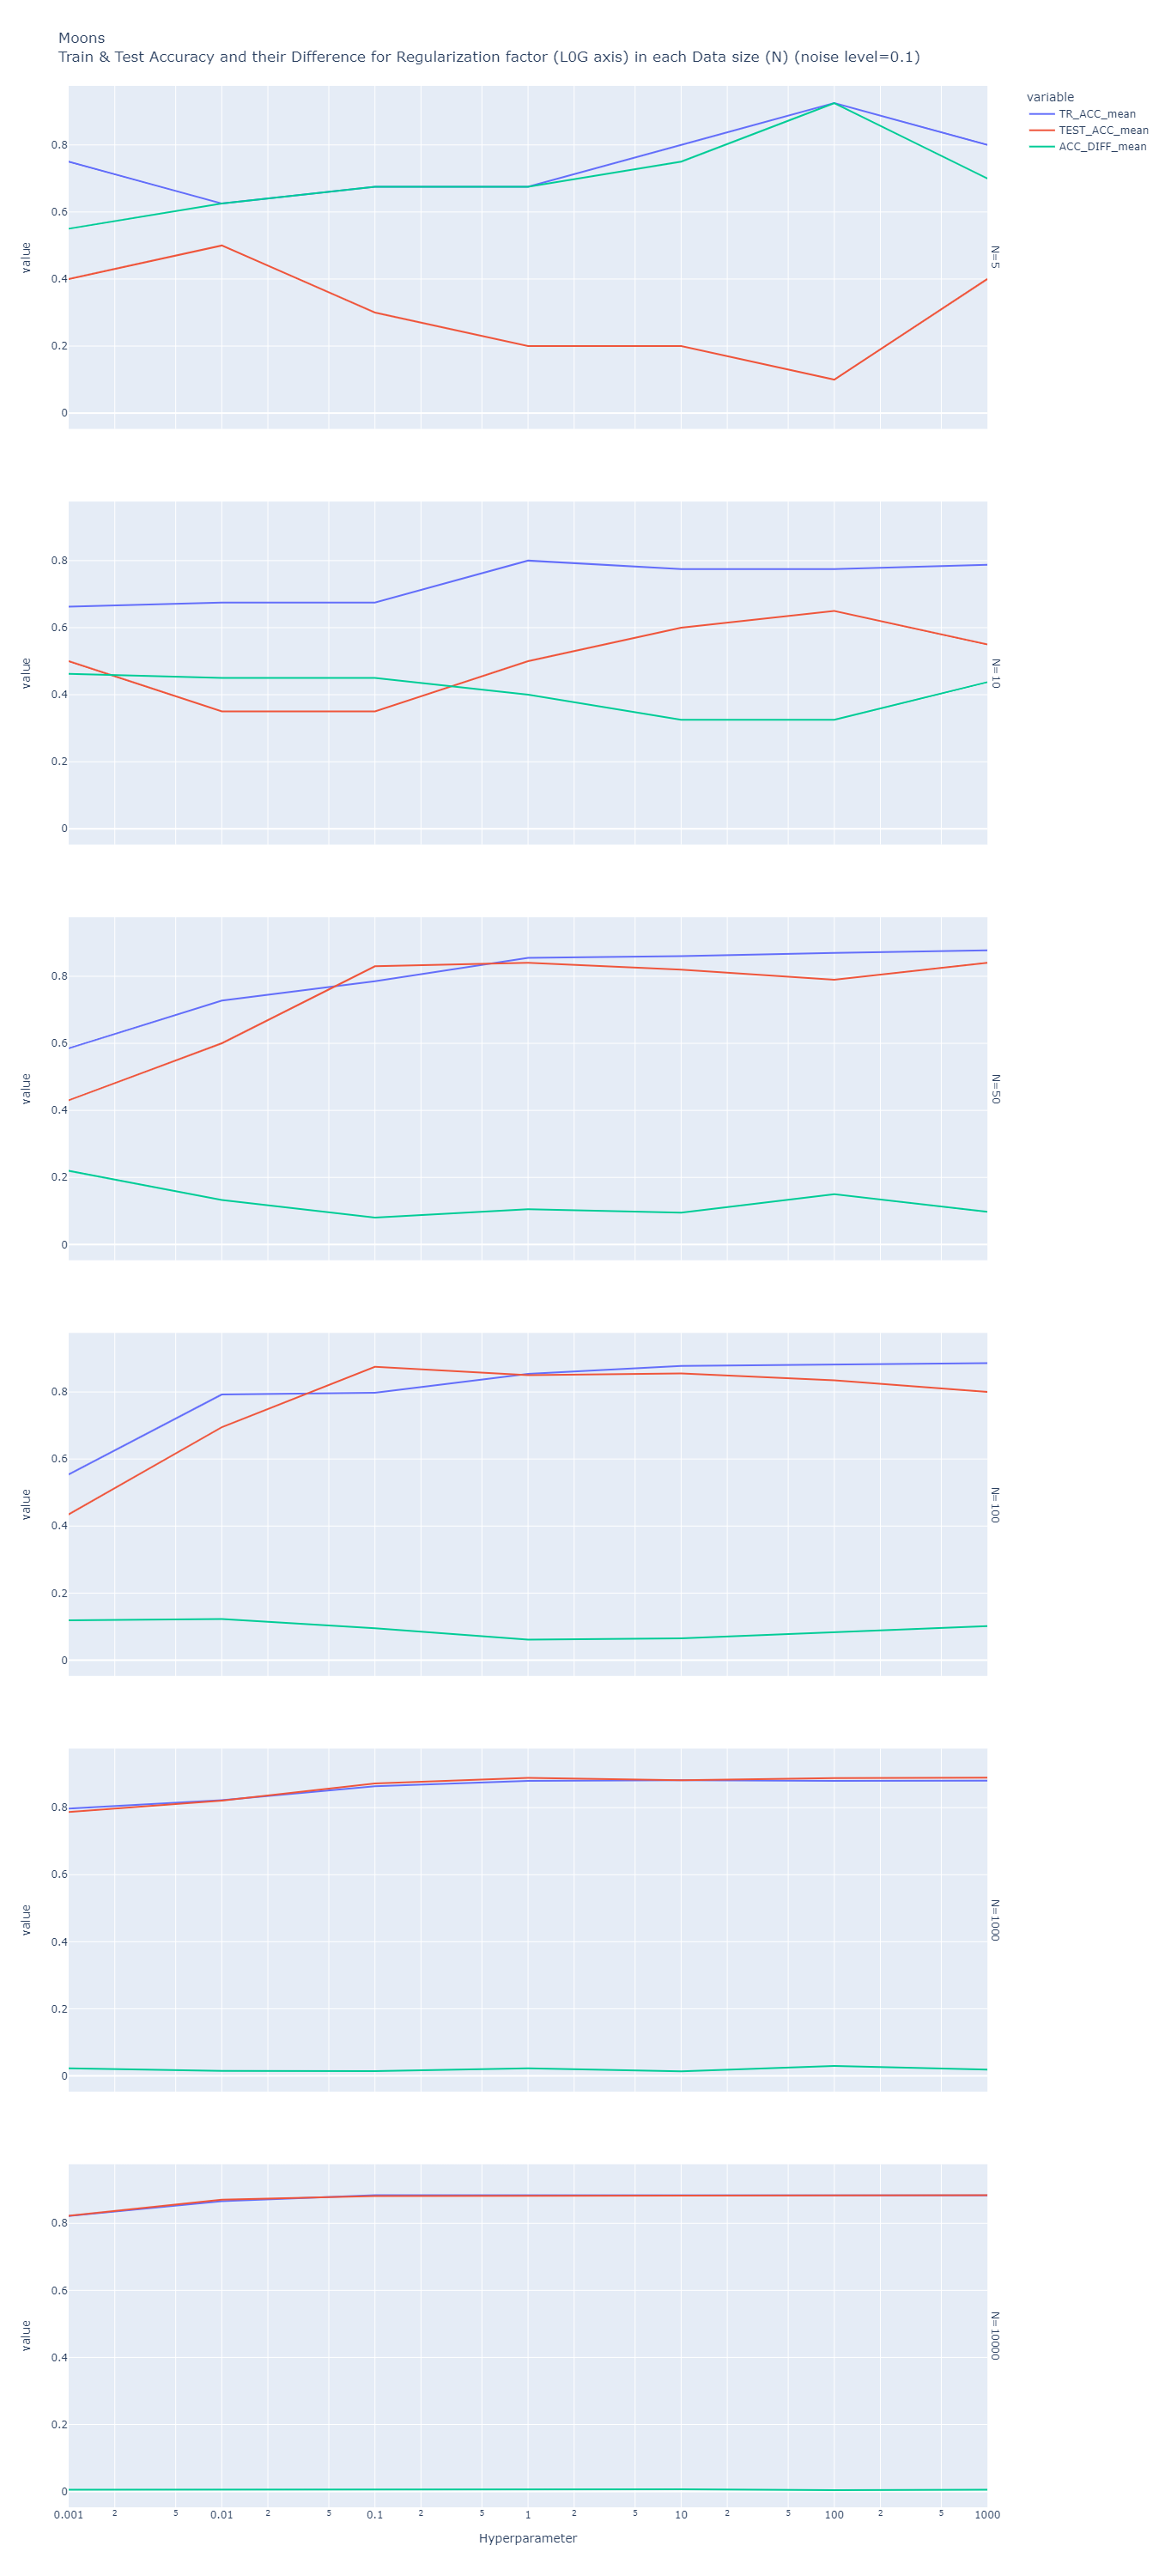

Circles


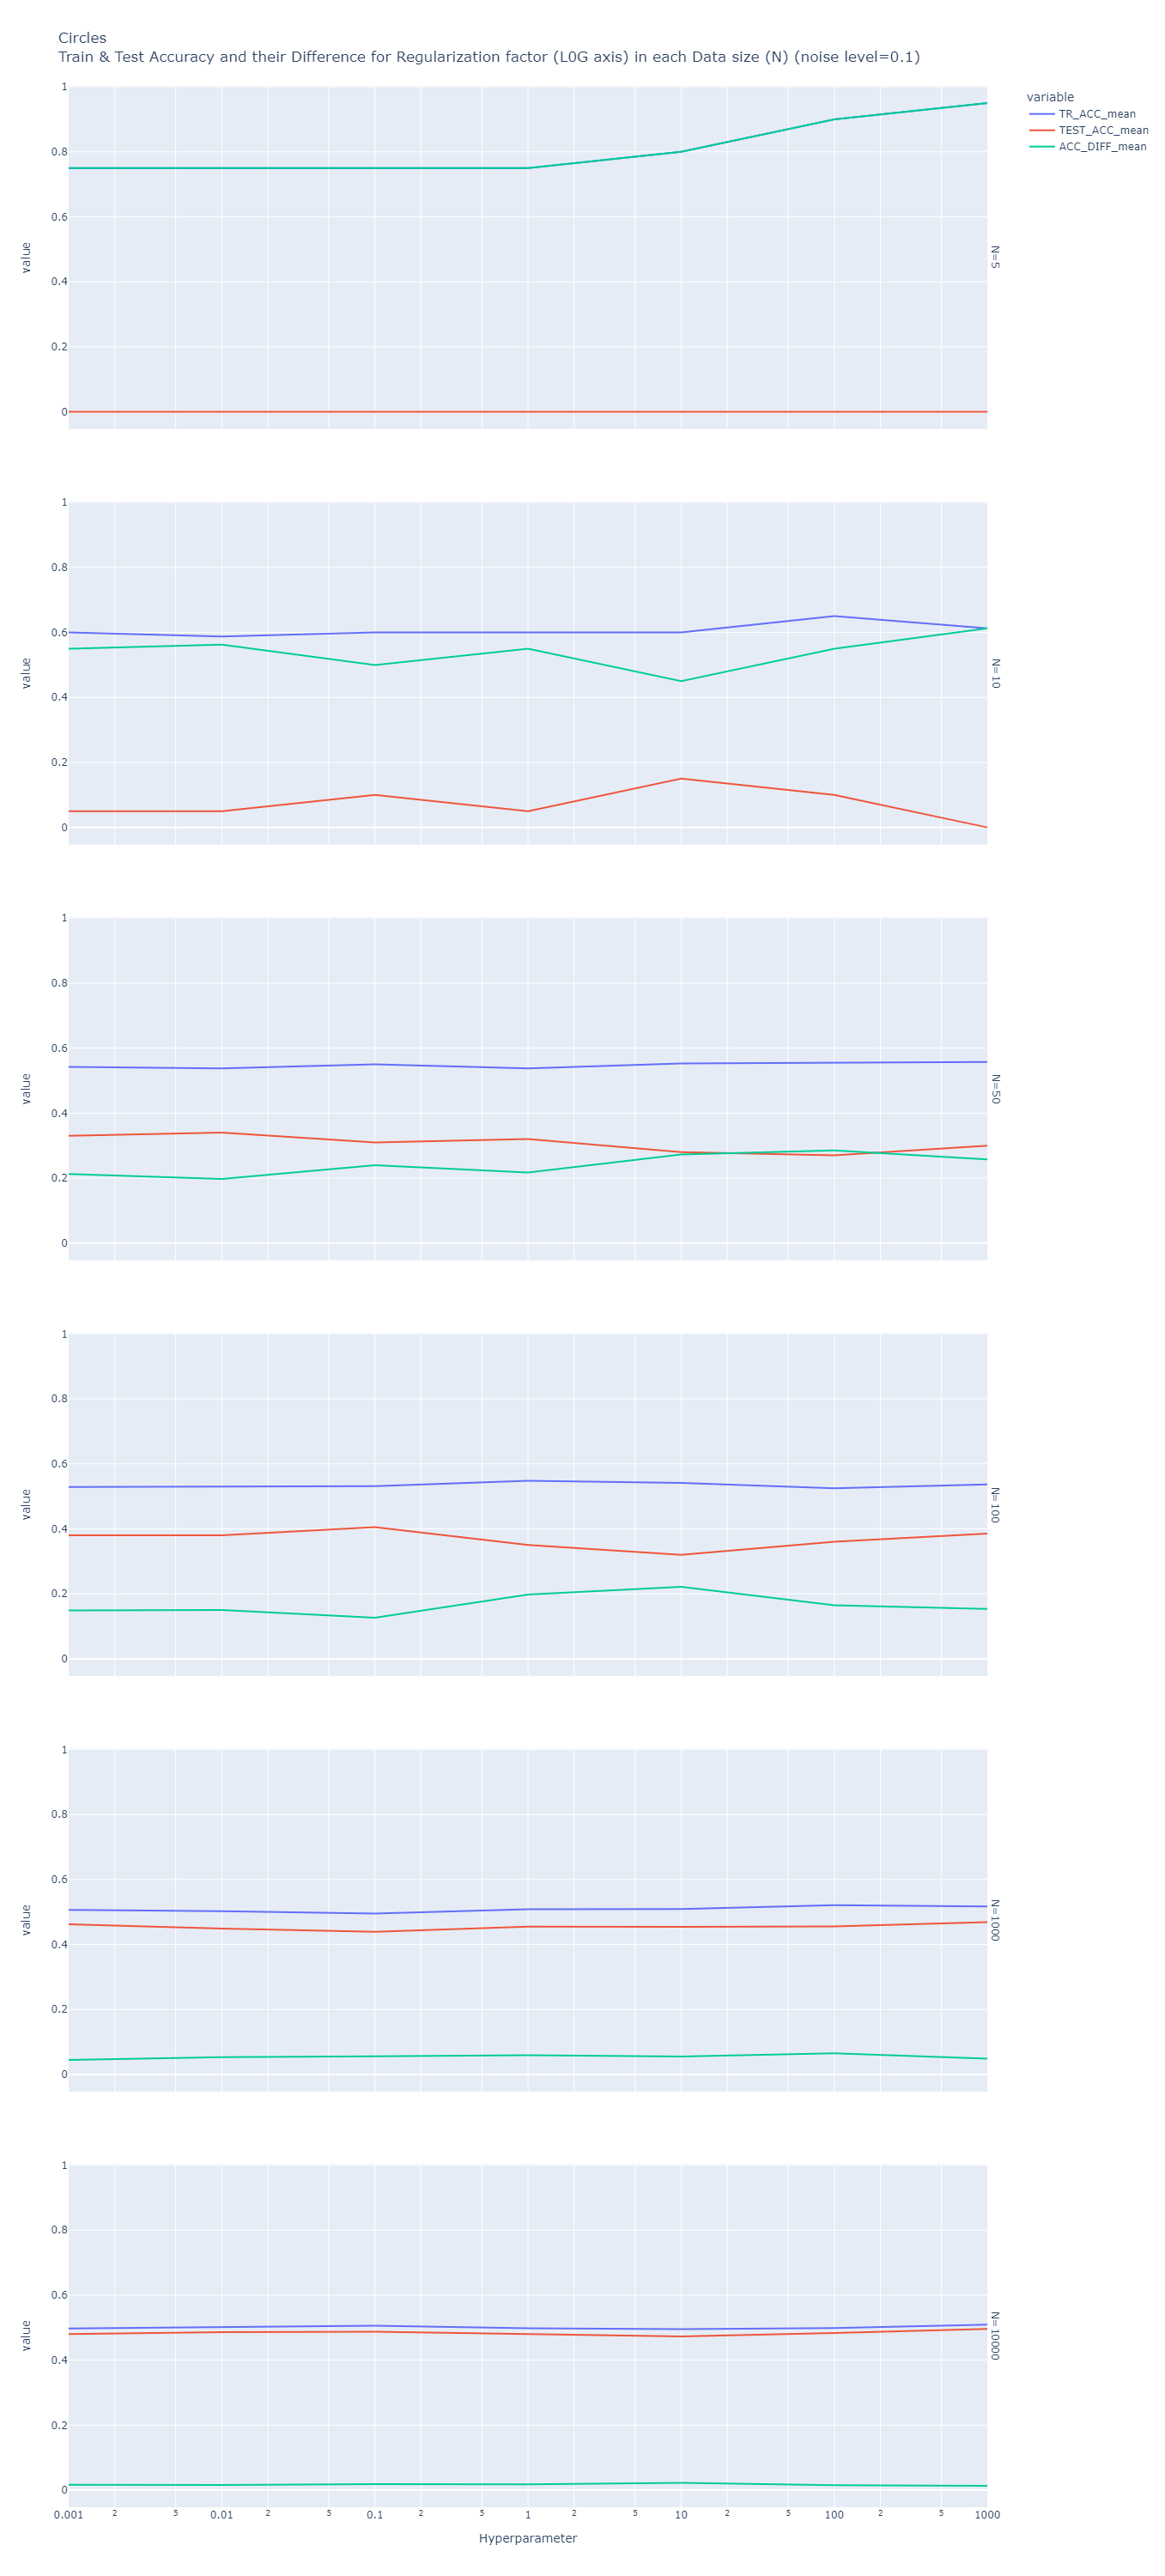

In [33]:
print("Logistic Regression")
df=df_k.copy().reset_index()
df = df[(df.CLF_NAME=="LogisticRegression") & (df.NL==0.1)]


moons_q4 = df.loc[df.DS_NAME=="Moons",:]
moons_q4 = moons_q4.reset_index(drop=True)
moons_q4 = moons_q4.sort_values(by=["NL","Hyperparameter"])

ds = "Moons"
plot_df = moons_q4.copy()
print(ds)
fig = px.line(data_frame=plot_df, x=plot_df.Hyperparameter, y=[plot_df.TR_ACC_mean, plot_df.TEST_ACC_mean, plot_df.ACC_DIFF_mean], facet_row=plot_df.N, facet_col=None, color=None, log_x=True, height=3000,
              title=f"{ds}<br>Train & Test Accuracy and their Difference for Regularization factor (L0G axis) in each Data size (N) (noise level=0.1)",
             labels={"TEST_ACC_mean":"Test Accuracy"})
fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])
fig.show()


circles_q4 = df.loc[df.DS_NAME=="Circles",:]
circles_q4 = circles_q4.reset_index(drop=True)
circles_q4 = circles_q4.sort_values(by=["NL","Hyperparameter"])

ds = "Circles"
plot_df = circles_q4.copy()
print(ds)
fig = px.line(data_frame=plot_df, x=plot_df.Hyperparameter, y=[plot_df.TR_ACC_mean, plot_df.TEST_ACC_mean, plot_df.ACC_DIFF_mean], facet_row=plot_df.N, facet_col=None, color=None, log_x=True, height=3000,
              title=f"{ds}<br>Train & Test Accuracy and their Difference for Regularization factor (L0G axis) in each Data size (N) (noise level=0.1)",
             labels={"TEST_ACC_mean":"Test Accuracy"})
fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])
fig.show()

In [34]:
print("""
Answer to Q5:

For LR:
In the Moons dataset, regularization causes an improvement in the difference between Train and Test accuracies, with overall good performance. The effects are less prominent in extreme values of N.
In the Circles dataset the performance is very poor, and the effects of the regularization are negligeable.
""")


Answer to Q5:

For LR:
In the Moons dataset, regularization causes an improvement in the difference between Train and Test accuracies, with overall good performance. The effects are less prominent in extreme values of N.
In the Circles dataset the performance is very poor, and the effects of the regularization are negligeable.



SVM
Moons


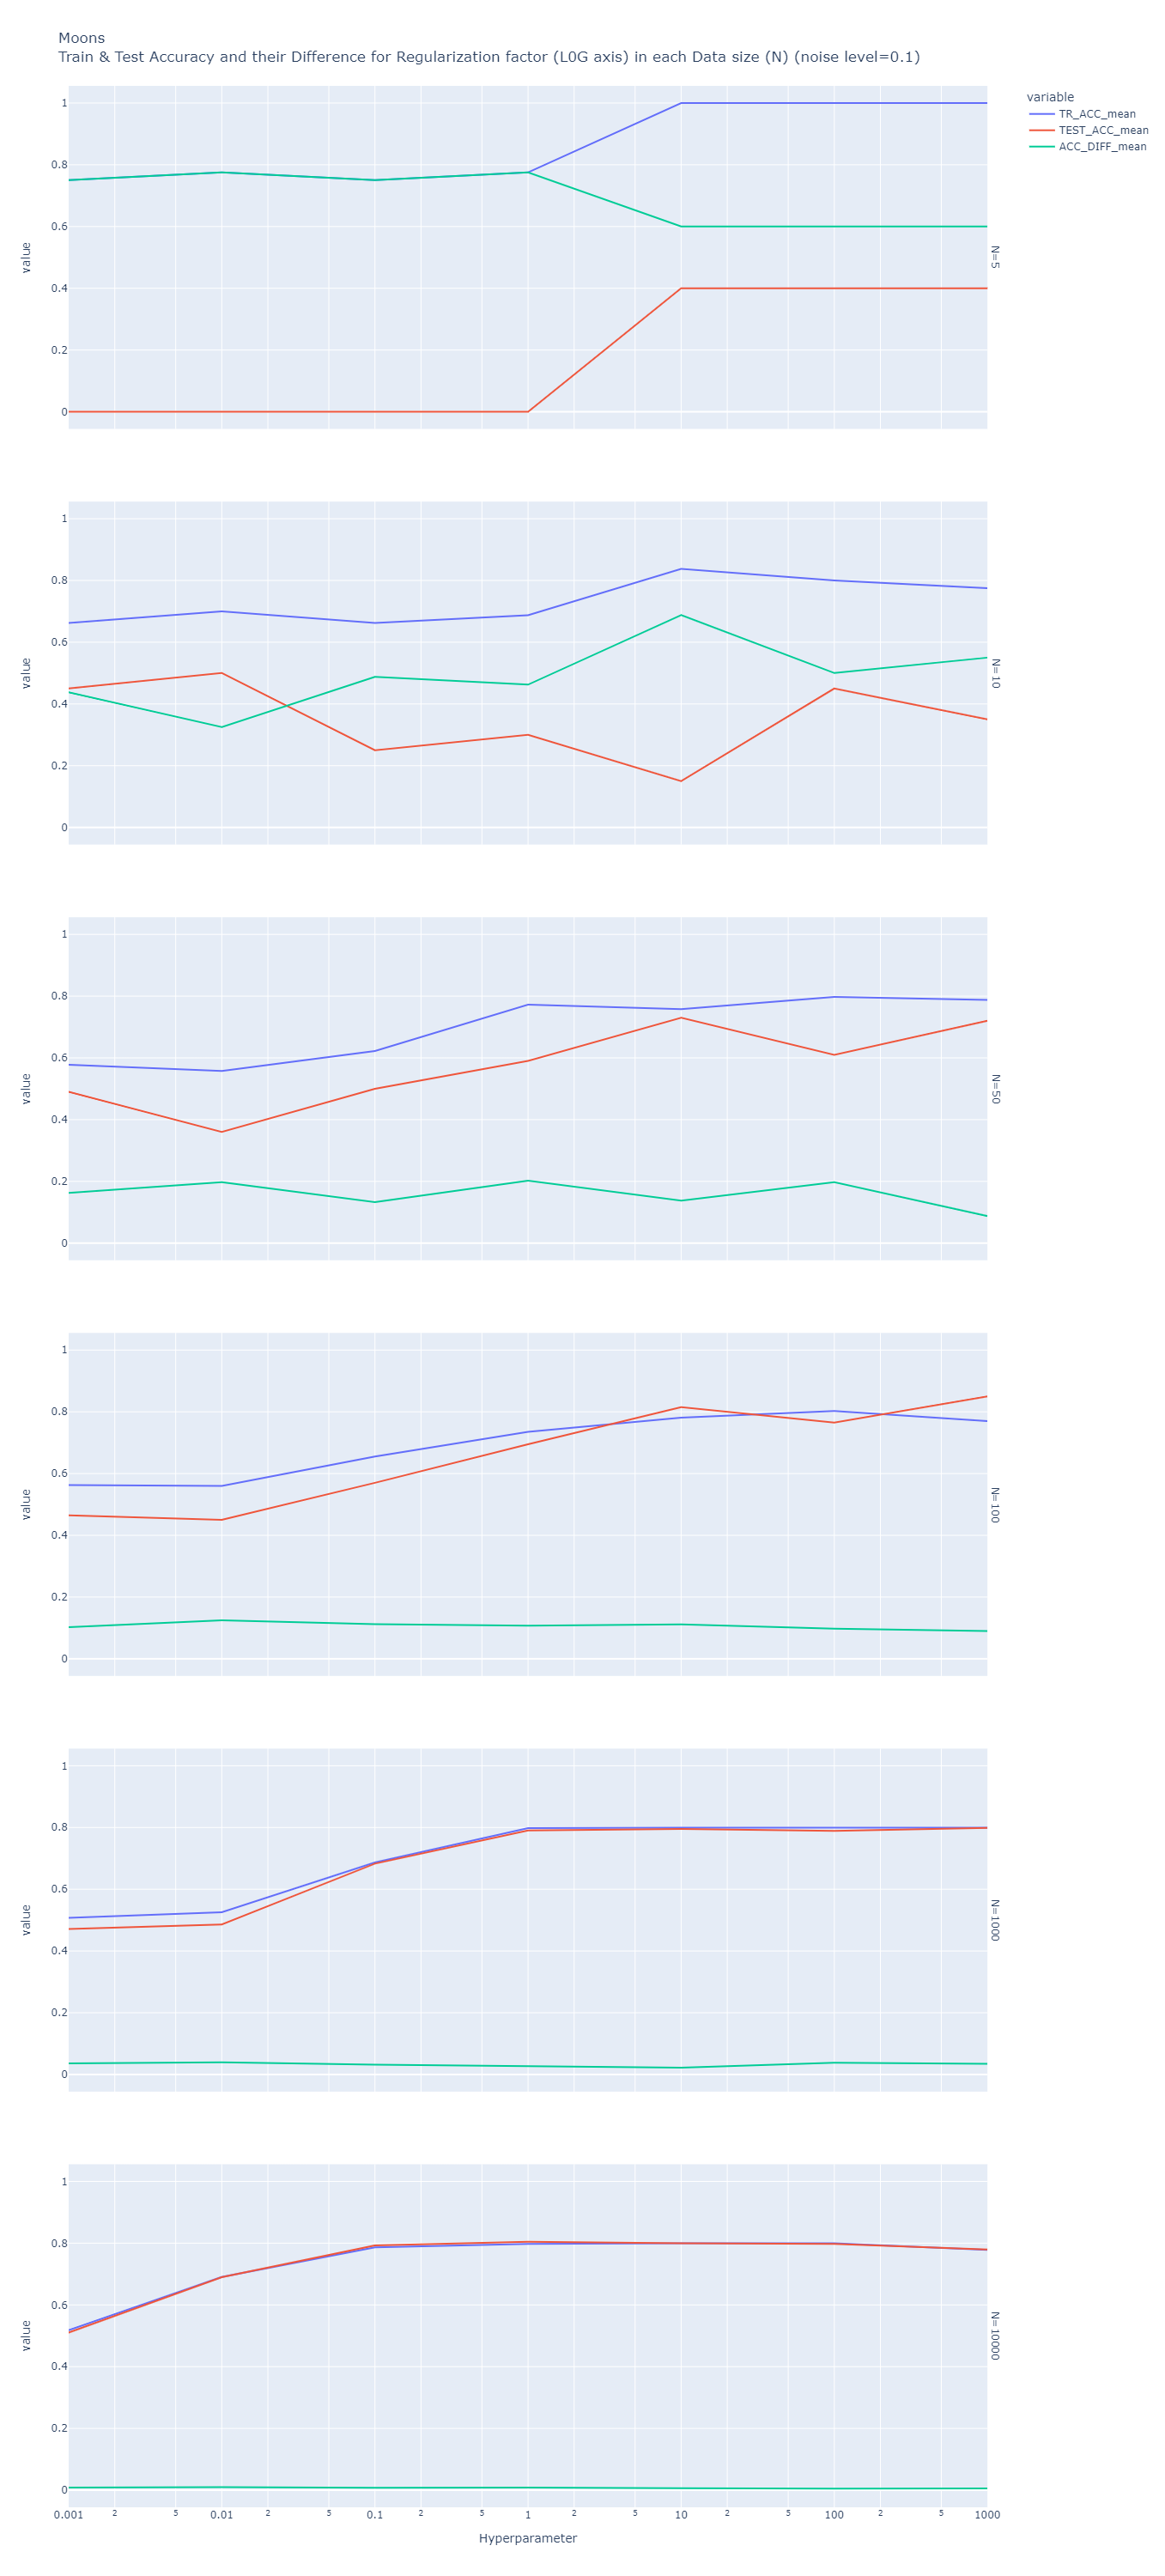

Circles


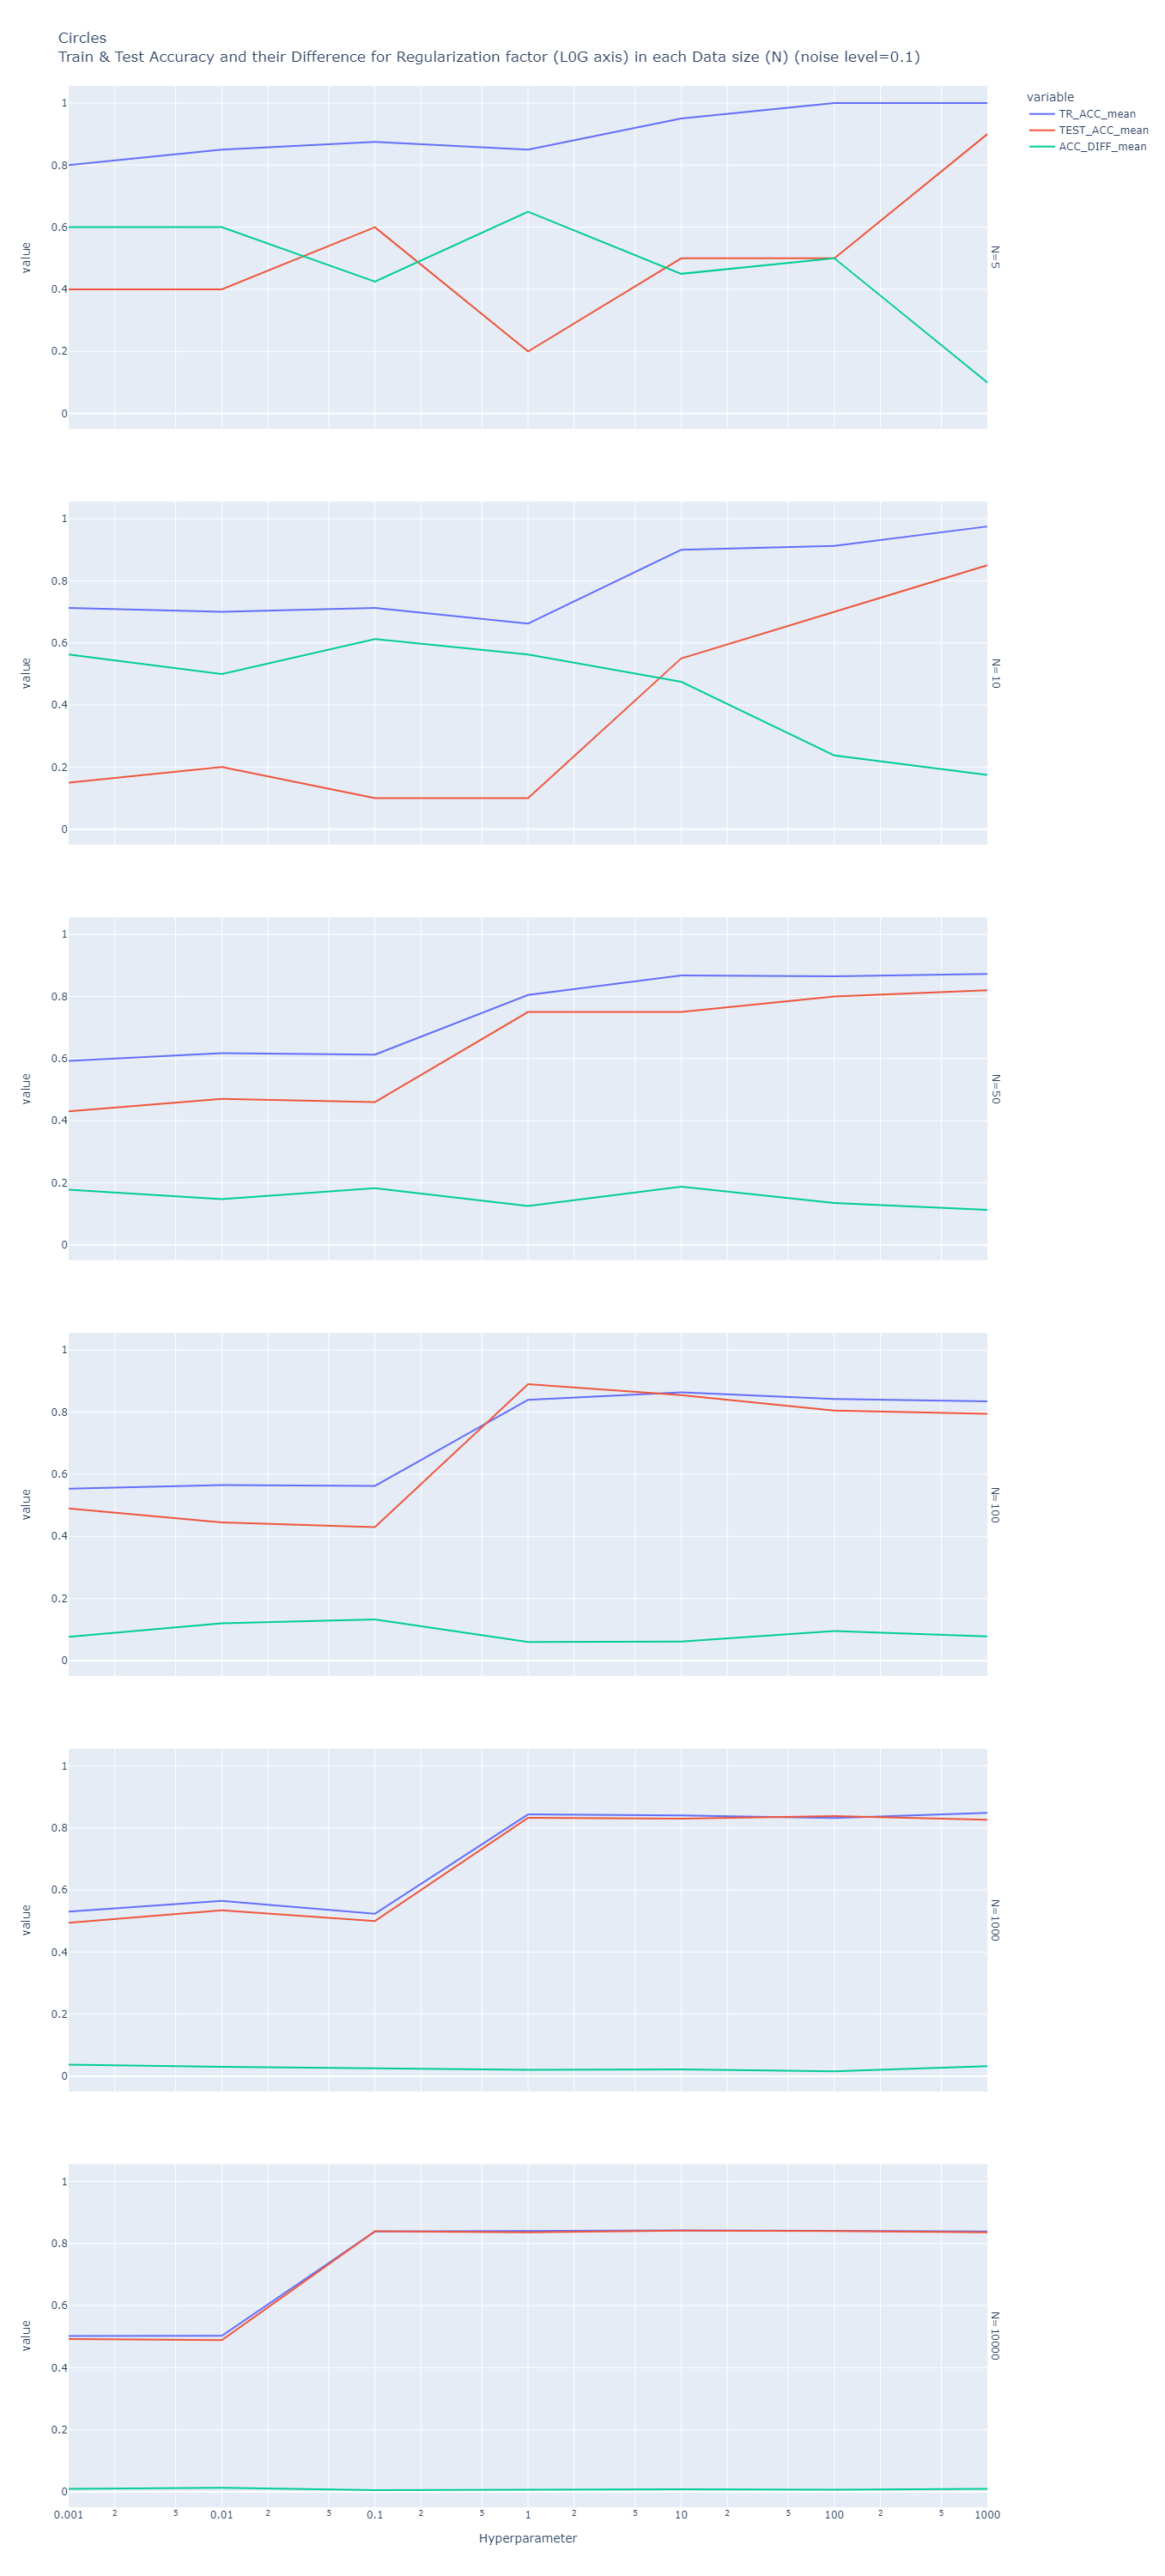

In [35]:
print("SVM")
df=df_k.copy().reset_index()
df = df[(df.CLF_NAME=="SVM") & (df.NL==0.1)]


moons_q4 = df.loc[df.DS_NAME=="Moons",:]
moons_q4 = moons_q4.reset_index(drop=True)
moons_q4 = moons_q4.sort_values(by=["NL","Hyperparameter"])

ds = "Moons"
plot_df = moons_q4.copy()
print(ds)
fig = px.line(data_frame=plot_df, x=plot_df.Hyperparameter, y=[plot_df.TR_ACC_mean, plot_df.TEST_ACC_mean, plot_df.ACC_DIFF_mean], facet_row=plot_df.N, facet_col=None, color=None, log_x=True, height=3000,
              title=f"{ds}<br>Train & Test Accuracy and their Difference for Regularization factor (L0G axis) in each Data size (N) (noise level=0.1)",
             labels={"TEST_ACC_mean":"Test Accuracy"})
fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])
fig.show()


circles_q4 = df.loc[df.DS_NAME=="Circles",:]
circles_q4 = circles_q4.reset_index(drop=True)
circles_q4 = circles_q4.sort_values(by=["NL","Hyperparameter"])

ds = "Circles"
plot_df = circles_q4.copy()
print(ds)
fig = px.line(data_frame=plot_df, x=plot_df.Hyperparameter, y=[plot_df.TR_ACC_mean, plot_df.TEST_ACC_mean, plot_df.ACC_DIFF_mean], facet_row=plot_df.N, facet_col=None, color=None, log_x=True, height=3000,
              title=f"{ds}<br>Train & Test Accuracy and their Difference for Regularization factor (L0G axis) in each Data size (N) (noise level=0.1)",
             labels={"TEST_ACC_mean":"Test Accuracy"})
fig_m1.update_layout(title_x=0.5)
fig_m1.update_yaxes(range=[0, 1])
fig.show()

In [36]:
print("""
Answer to Q5:

For SVM:
In the Moons dataset, The difference between the Train and Test accuracies doesn't change much, but the overall performance increases significantly with the model complexity.
In the Circles dataset, the effects are similar, but in N <= 10 , it also possible to observe a decrease in the accuracy difference.
""")


Answer to Q5:

For SVM:
In the Moons dataset, The difference between the Train and Test accuracies doesn't change much, but the overall performance increases significantly with the model complexity.
In the Circles dataset, the effects are similar, but in N <= 10 , it also possible to observe a decrease in the accuracy difference.



6. Are the noise level effect the number of datapoints needed to reach optimal test results? 

In [37]:
print("""
Answer to Q6:

As shown by the graphs presented for Q3 - The performance improves significantly with the addition of datapoints, in each given noise level.
i.e. even without any noise, there is a clear pattern of improvement in that direction. It persists in the same manner with growing noise levels.
So, although noise will cause the final performance to be worse, it actually lowers the "optimal" test results, but does not cause reaching that optimum to require more datapoints than with a lower noise level.
""")


Answer to Q6:

As shown by the graphs presented for Q3 - The performance improves significantly with the addition of datapoints, in each given noise level.
i.e. even without any noise, there is a clear pattern of improvement in that direction. It persists in the same manner with growing noise levels.
So, although noise will cause the final performance to be worse, it actually lowers the "optimal" test results, but does not cause reaching that optimum to require more datapoints than with a lower noise level.

